In [1]:
# 에포크마다 사진으로 출력하여 변화 관찰

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')

print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('mnist',train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist',train=False, transform=transform)
train_loader = DataLoader(train_dataset, num_workers=8,shuffle=True,batch_size=32)
test_loader = DataLoader(test_dataset, num_workers=8,shuffle=True,batch_size=32)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
type(train_dataset[0][0])

torch.Tensor

In [6]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv_layer = nn.Sequential(
            # 32,1,28,28
            nn.Conv2d(1, 32, 5,padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 32,32,14,14
            nn.Conv2d(32, 64, 5,padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 32.64.7.7
            nn.Conv2d(64, 128, 5,padding=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, 5,padding=2),
            nn.ReLU(),
            # 32,128,7,7
            nn.Conv2d(128, 2, 7), # 32,2,1,1
            nn.AdaptiveAvgPool2d(1),
        )
        # 32,1,1,1
        self.classifier = nn.Linear(2, 10)
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.shape[0], 2)
        x = self.classifier(x)
        return x
    
    def get_feature(self, x):
        with torch.no_grad():
            x = self.conv_layer(x)
            # 32 1 1 1
            x = x.view(x.shape[0], 2)
            # 32 2
            return x

In [8]:
lenet = LeNet().to(device)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss() # softmax 이미 포함
optimizer = optim.SGD(lenet.parameters(), lr=learning_rate)

In [9]:
train_losses = []
train_accuracy = []

In [10]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

In [11]:
def get_samples_vector(net, dataloader, num_samples=1000):
    samples = []
    labels = []
    for x, y in dataloader:
        sample = net.get_feature(x.cuda()) # normalized vector
        samples.extend(sample.tolist())
        labels.extend(y.tolist())
        if len(samples) > num_samples:
            break
    samples = list(zip(samples, labels))
    return samples, labels



In [12]:
def show_2d_space(samples, labels, w,count):
    plt.figure(figsize=(10,10))
    for i in range(10):
        samples_i = list(filter(lambda x : x[1] == i, samples))
        samples_feat = np.ndarray.flatten(np.array([s[0] for s in samples_i]))
        plt.plot(*samples_feat, marker="o", color=colors[i], markersize=1)
        plt.plot([w[i][0], 0], [w[i][1], 0], color=colors[i])
    # plt.plot(*zip(w, [[0,0] for i in range(10)]))
    plt.savefig(count+'.png')
    #plt.show()

In [13]:
def train(net,epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, prediction = outputs.max(1)

        total += labels.size(0)
        correct += prediction.eq(labels).sum().item()

        if batch_idx % 500 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current train accuracy:', str(prediction.eq(labels).sum().item() / labels.size(0)))
            print('Current train average loss:', loss.item() / 100)


    train_losses.append(train_loss / total)
    train_accuracy.append(100. * correct / total)
    print('\nTrain accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    
    lenet_samples, lenet_labels = get_samples_vector(lenet, dataloader=train_loader, num_samples=1000)
    lenet_w = F.normalize(lenet.classifier.weight).tolist()
    show_2d_space(lenet_samples, lenet_labels, lenet_w,str(epoch))


def test(net,epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        total += labels.size(0)

        outputs = net(images)
        loss += criterion(outputs, labels).item()

        _, prediction = outputs.max(1)
        correct += prediction.eq(labels).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)


[ Train epoch: 0 ]


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Current batch: 0
Current train accuracy: 0.09375
Current train average loss: 0.02399061918258667

Current batch: 500
Current train accuracy: 0.0625
Current train average loss: 0.023599419593811035

Current batch: 1000
Current train accuracy: 0.15625
Current train average loss: 0.0226401686668396

Current batch: 1500
Current train accuracy: 0.1875
Current train average loss: 0.02263577699661255

Train accuarcy: 17.383333333333333
Train average loss: 0.06758338090578715

[ Train epoch: 1 ]

Current batch: 0
Current train accuracy: 0.53125
Current train average loss: 0.01282451868057251

Current batch: 500
Current train accuracy: 0.84375
Current train average loss: 0.006668717861175537

Current batch: 1000
Current train accuracy: 0.84375
Current train average loss: 0.005384395122528076

Current batch: 1500
Current train accuracy: 0.84375
Current train average loss: 0.005155149102210999

Train accuarcy: 75.94666666666667
Train average loss: 0.02365325414488713

[ Train epoch: 2 ]

Current


Train accuarcy: 99.375
Train average loss: 0.000678693500951052

[ Train epoch: 17 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 1.4696733560413122e-05

Current batch: 500
Current train accuracy: 0.96875
Current train average loss: 0.0004153045639395714

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 8.327508345246315e-05

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 1.4102805871516465e-05

Train accuarcy: 99.44166666666666
Train average loss: 0.0006424131217232571

[ Train epoch: 18 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 0.00022073881700634956

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 4.513679072260857e-05

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 0.00010550720617175102

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 4.670314956456423e-05

Train accuarcy: 99.3516

<ipython-input-12-4dead908f5f1>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))



[ Train epoch: 21 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 6.1020334251224994e-05

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 1.0054261656478047e-05

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 9.976924629881979e-06

Current batch: 1500
Current train accuracy: 0.96875
Current train average loss: 0.0003305226191878319

Train accuarcy: 99.47
Train average loss: 0.0005887004079237613

[ Train epoch: 22 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 2.0620666327886285e-06

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 7.317674346268176e-05

Current batch: 1000
Current train accuracy: 0.96875
Current train average loss: 0.0007426512241363526

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 1.0660934494808316e-05

Train accuarcy: 99.63166666666666
Train average loss: 0.00037881002132108865

[ Train epoch: 23 


Train accuarcy: 99.97833333333334
Train average loss: 2.7009968235557846e-05

[ Train epoch: 38 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 1.5396724847960286e-07

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 1.750850742610055e-08

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 8.712966809980572e-06

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 1.2710144801530987e-06

Train accuarcy: 99.98833333333333
Train average loss: 1.4077159913300352e-05

[ Train epoch: 39 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 8.477302617393434e-07

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 8.58970179251628e-08

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 8.95699777174741e-07

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 2.2314998204819858e-07

Train accuarcy: 


Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 2.3040309315547347e-07

Train accuarcy: 99.995
Train average loss: 1.1132431404952219e-05

[ Train epoch: 55 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 7.615299546159804e-07

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 1.5478495697607285e-07

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 4.458127295947634e-07

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 1.0505214049771893e-08

Train accuarcy: 99.99833333333333
Train average loss: 4.3173956428925665e-06

[ Train epoch: 56 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 1.3326602129382082e-07

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 1.1441095266491174e-05

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 2.761711657512933e-06

Current batch: 1500
Cur


Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 2.501286326150876e-07

Train accuarcy: 100.0
Train average loss: 7.278266420602697e-07

[ Train epoch: 72 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 1.7452795873396098e-06

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 0.0

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 1.0803155419125687e-08

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 3.233440565963974e-08

Train accuarcy: 100.0
Train average loss: 6.99469583491663e-07

[ Train epoch: 73 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 1.862644971595273e-10

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 2.1084624677314424e-08

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 7.077971417857043e-09

Current batch: 1500
Current train accuracy: 1.0
Current tra


Train accuarcy: 100.0
Train average loss: 4.3019852153813137e-07

[ Train epoch: 89 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 1.992992793020676e-08

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 3.1593834137311206e-07

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 8.828874342725613e-09

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 9.201343686982e-09

Train accuarcy: 100.0
Train average loss: 4.2009275471400026e-07

[ Train epoch: 90 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 8.19562870901791e-10

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 1.1118071597593371e-07

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 7.036359420453664e-08

Current batch: 1500
Current train accuracy: 1.0
Current train average loss: 4.335883568273857e-07

Train accuarcy: 100.0
Train average loss: 4

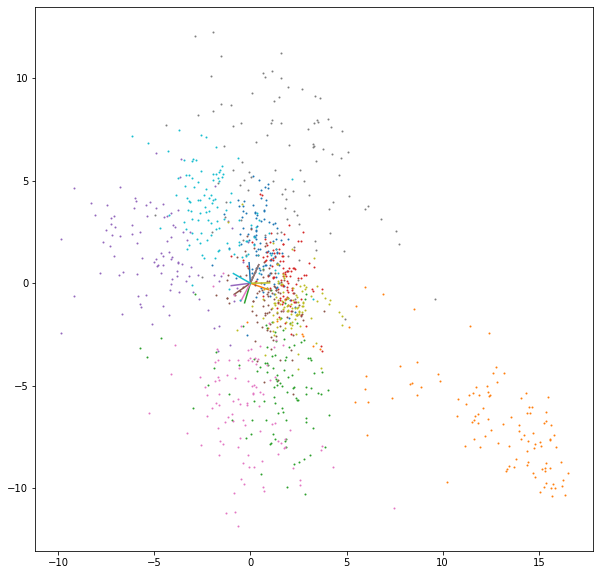

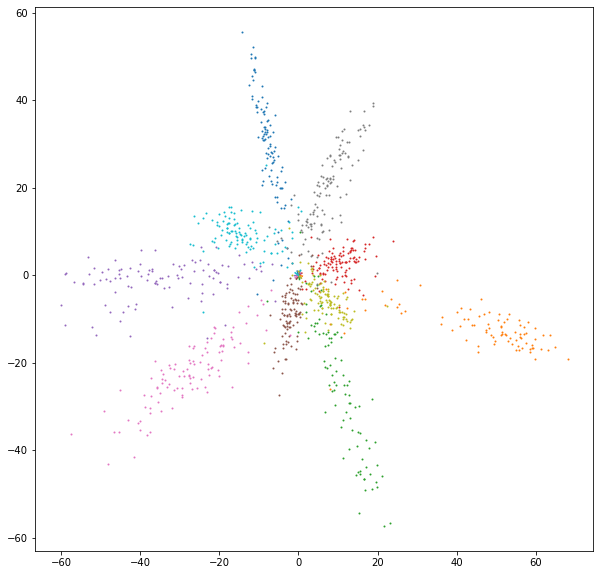

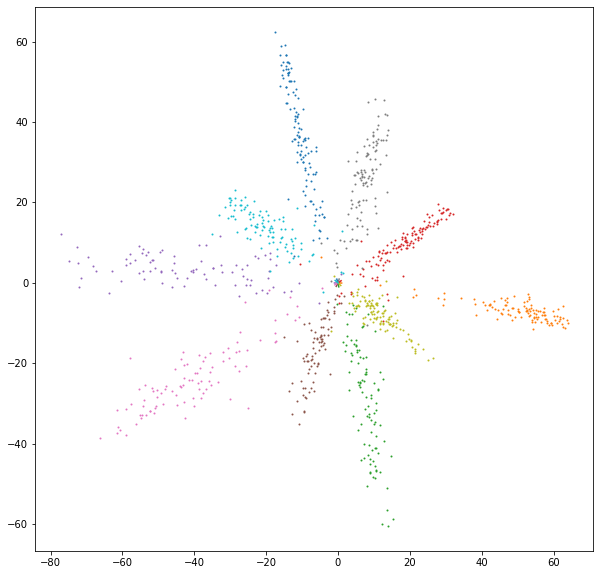

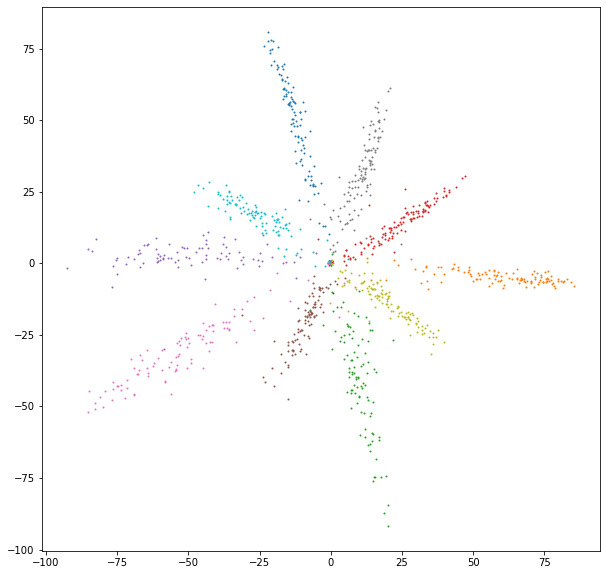

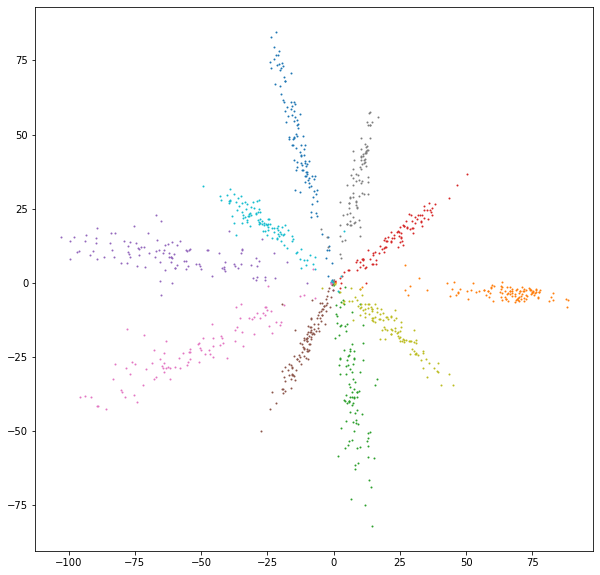

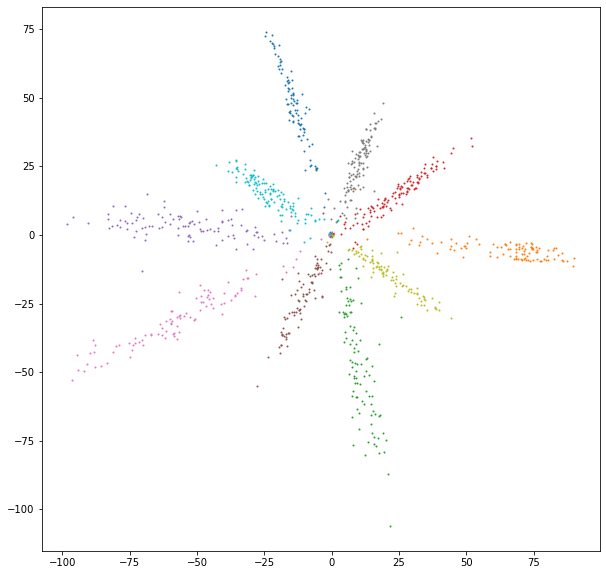

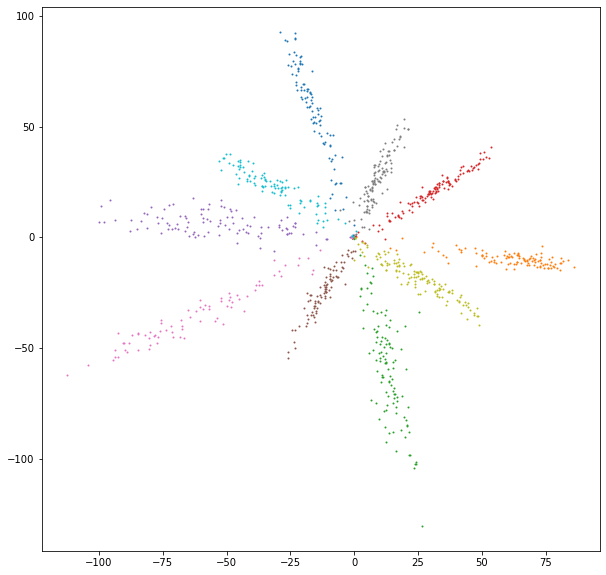

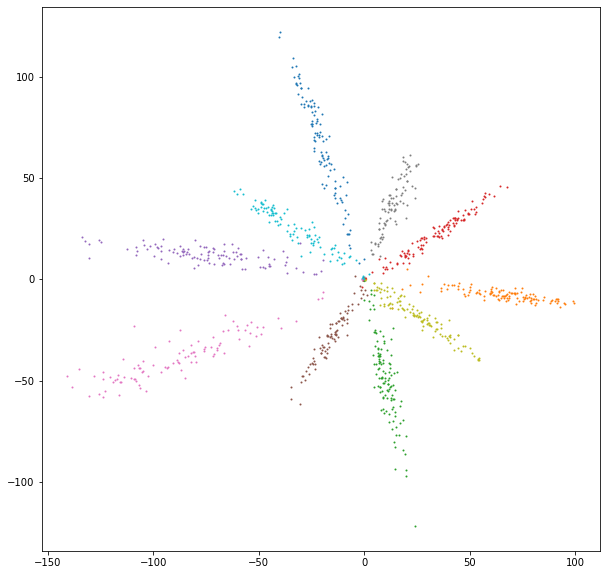

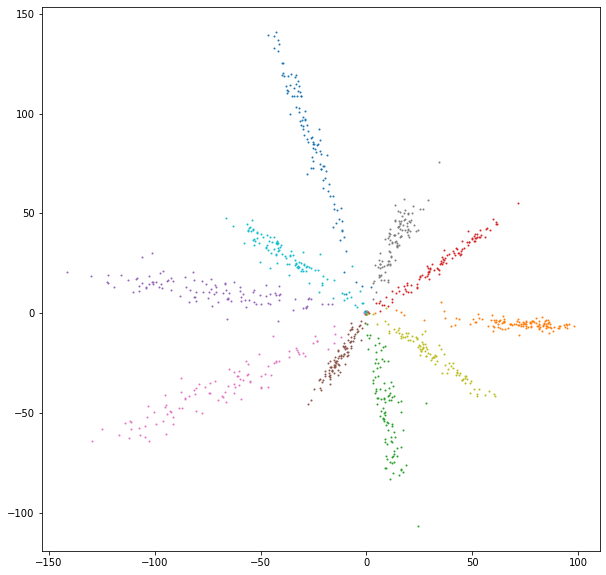

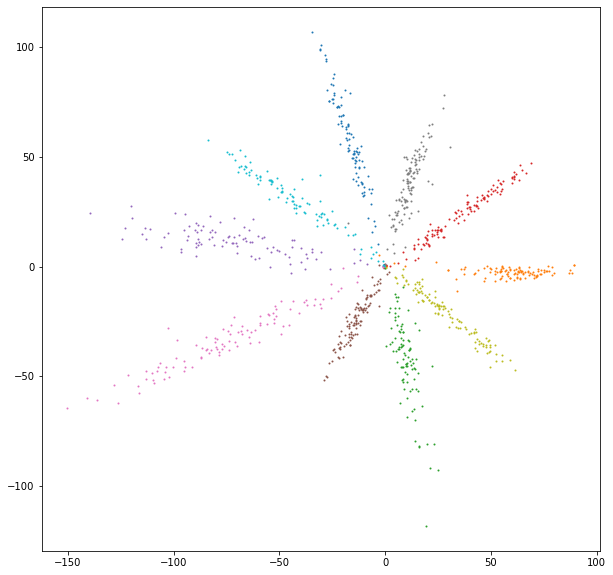

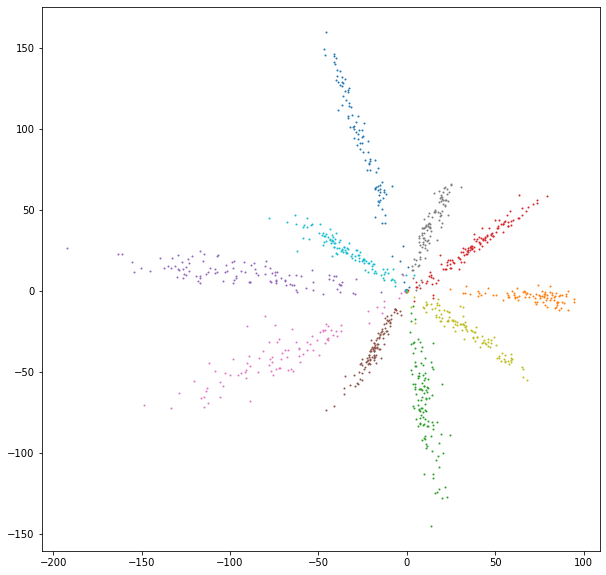

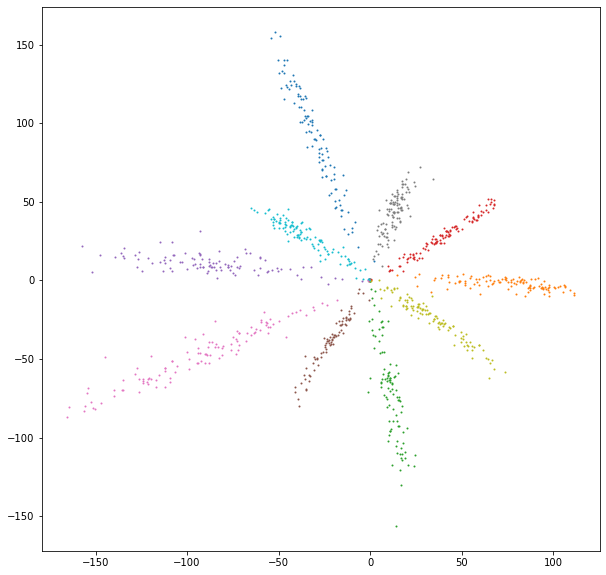

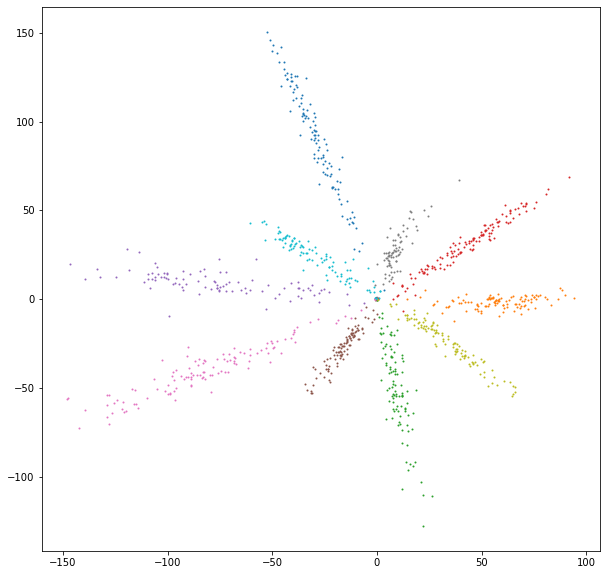

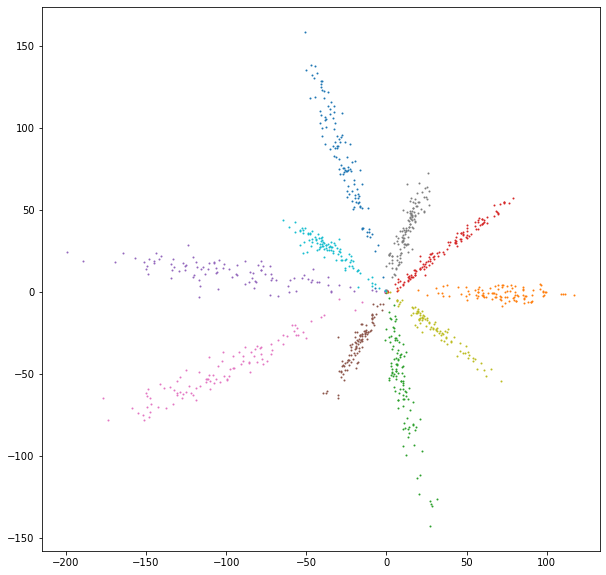

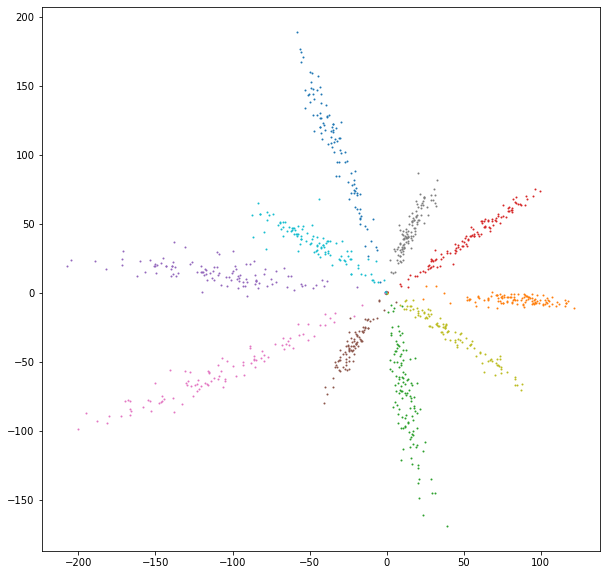

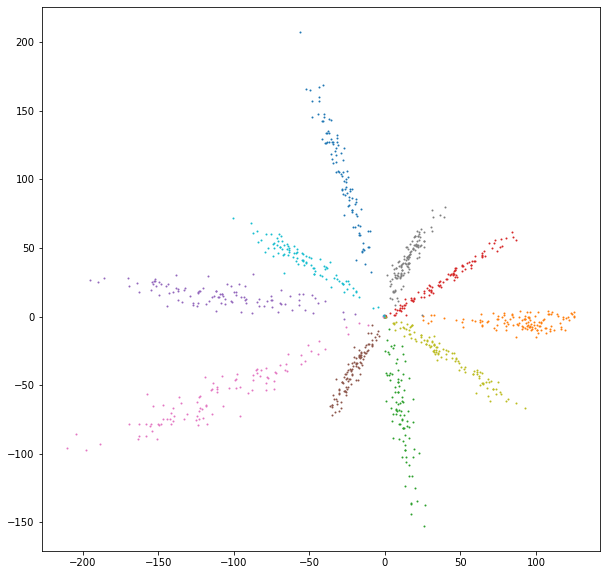

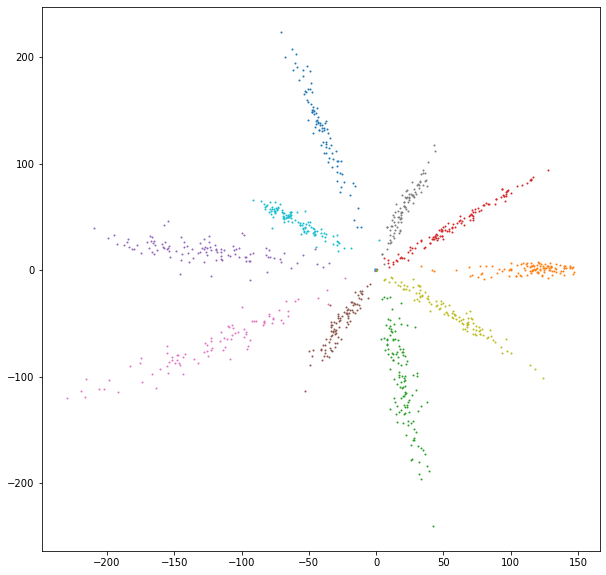

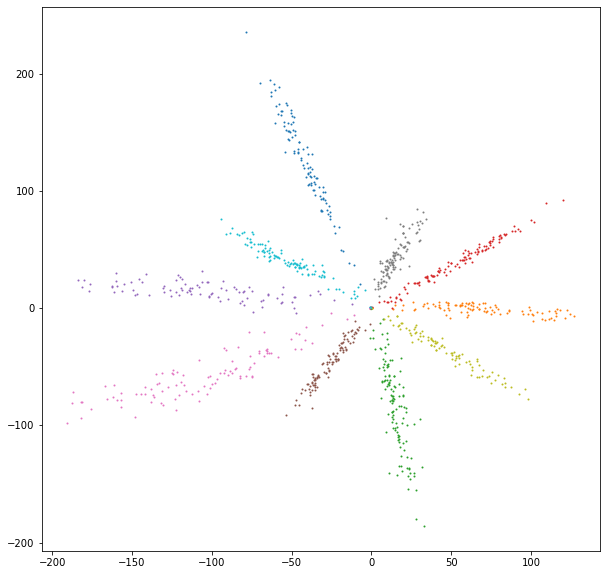

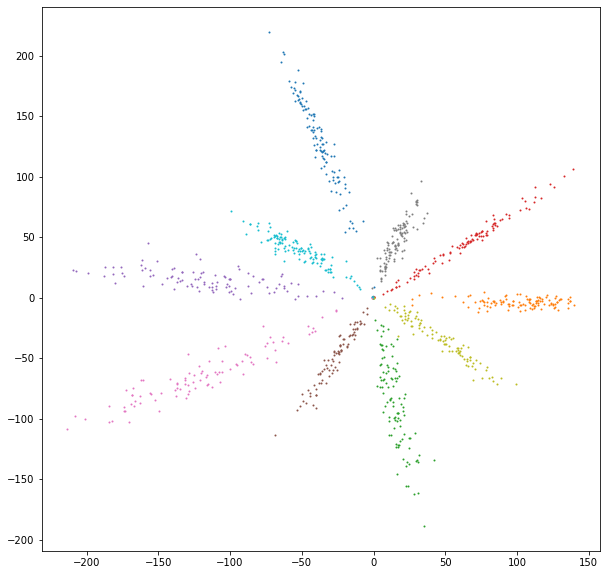

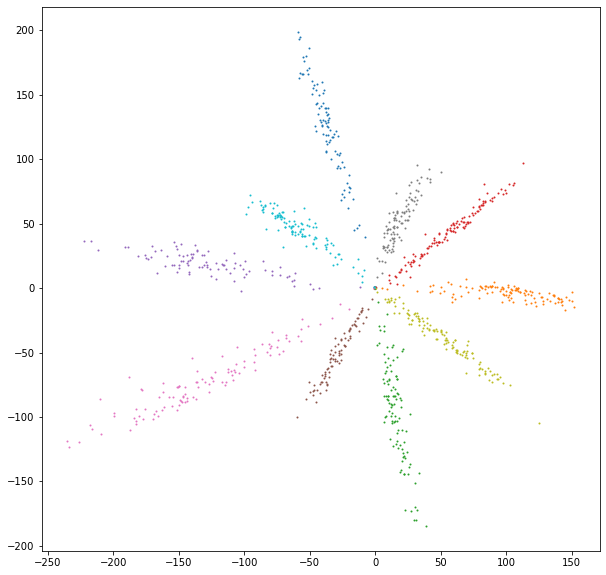

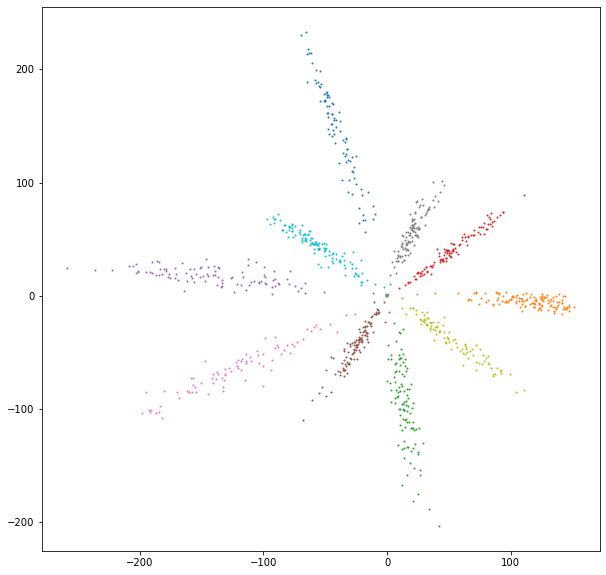

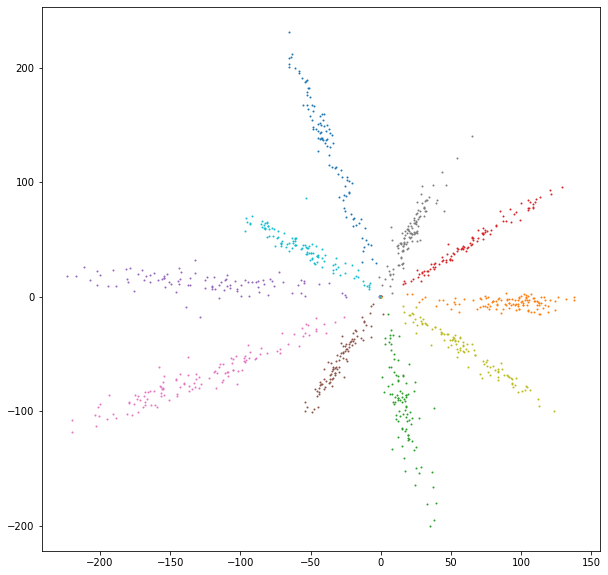

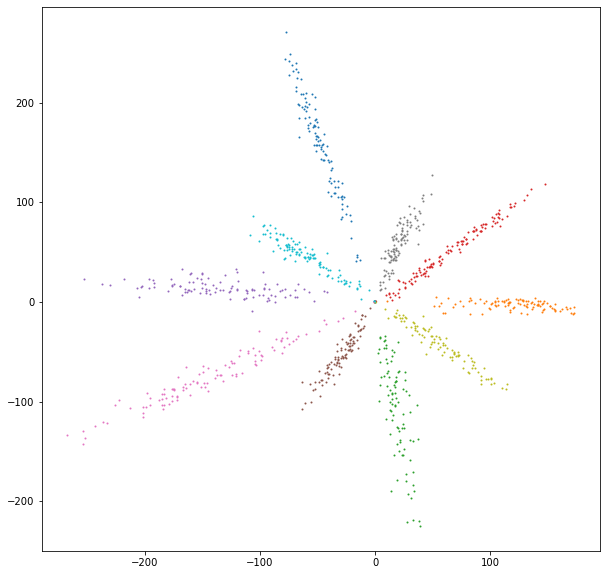

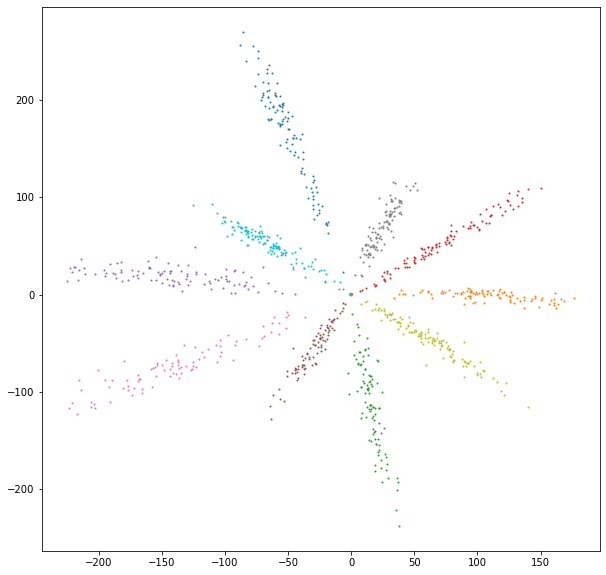

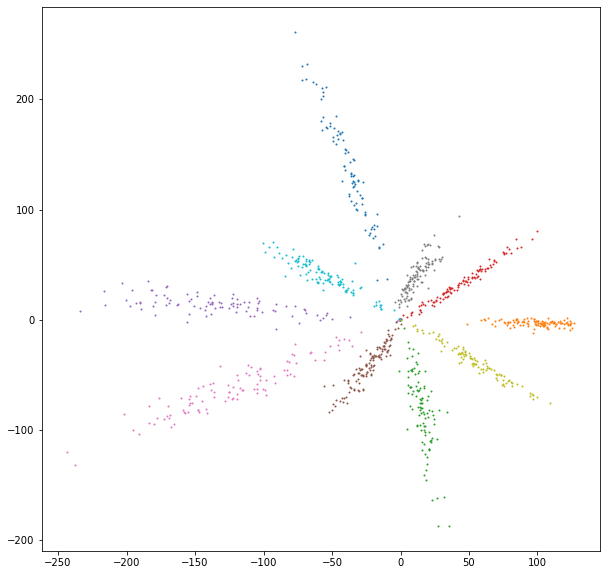

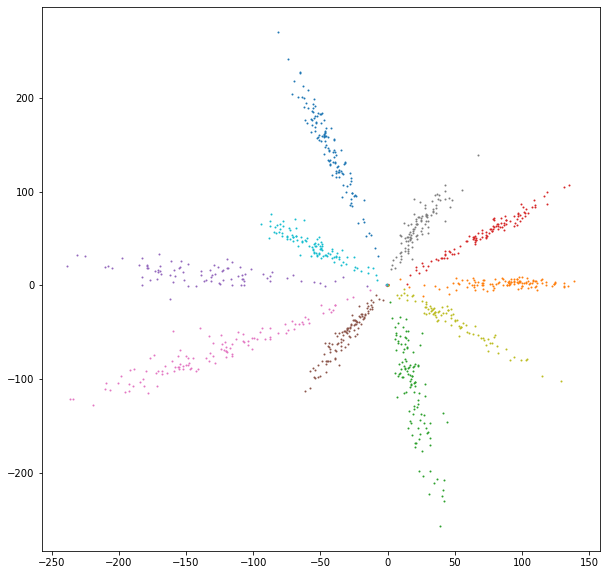

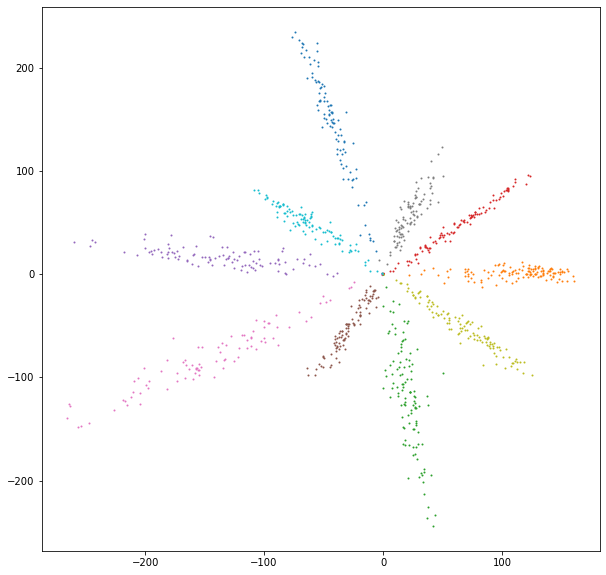

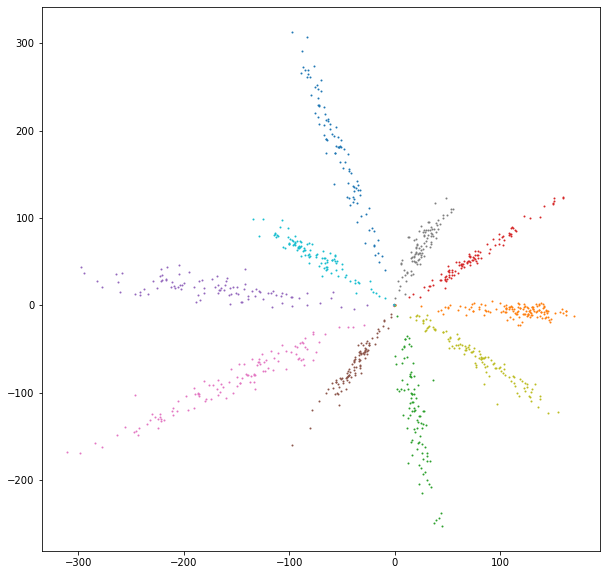

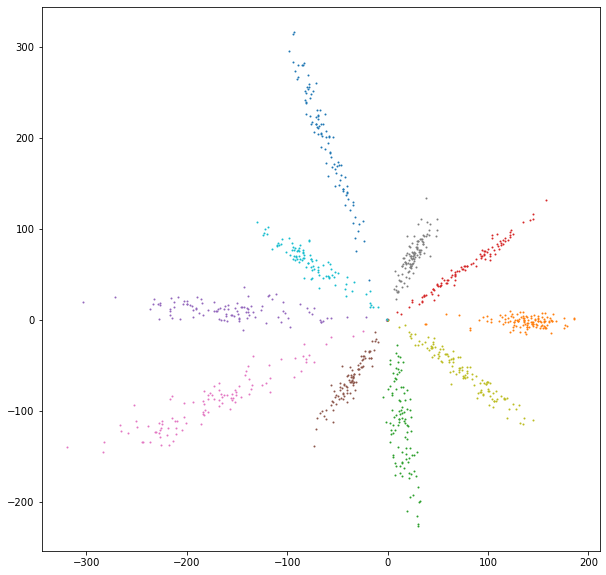

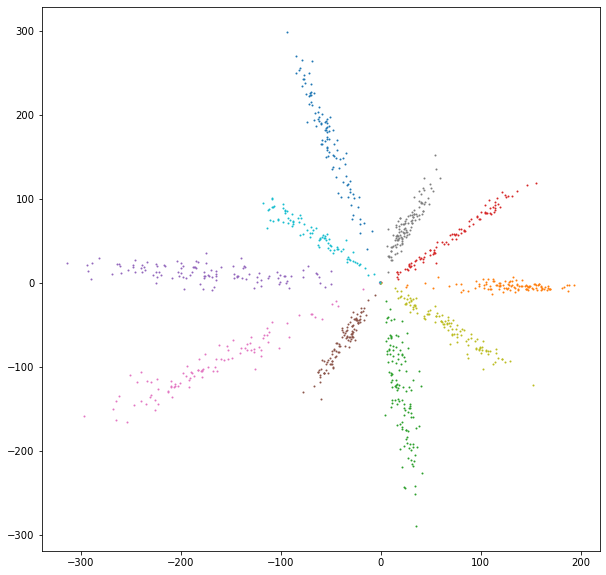

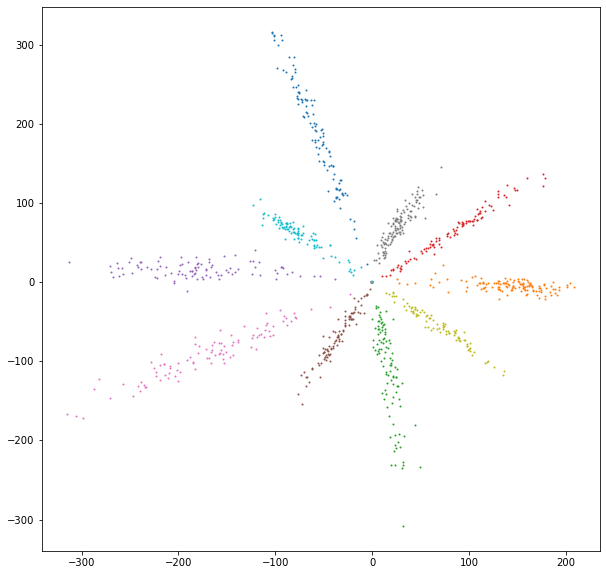

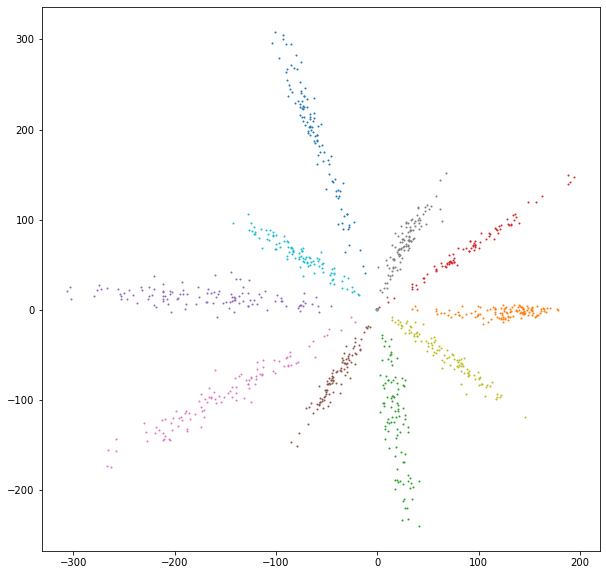

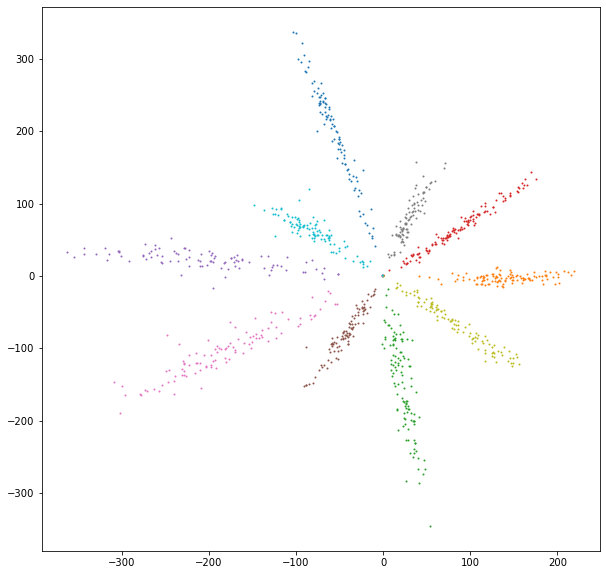

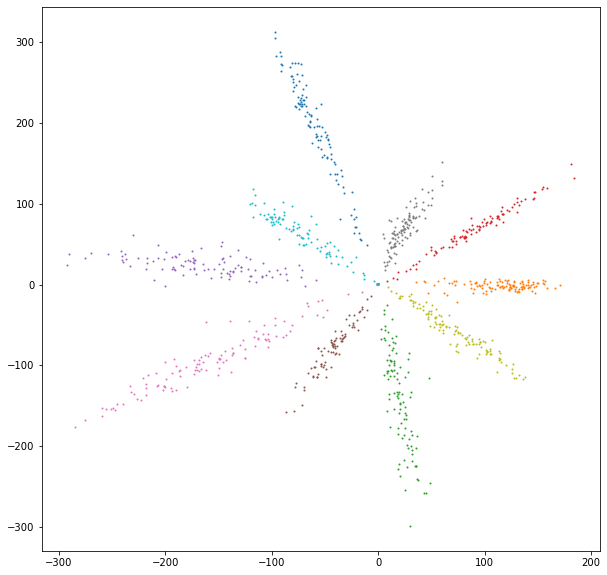

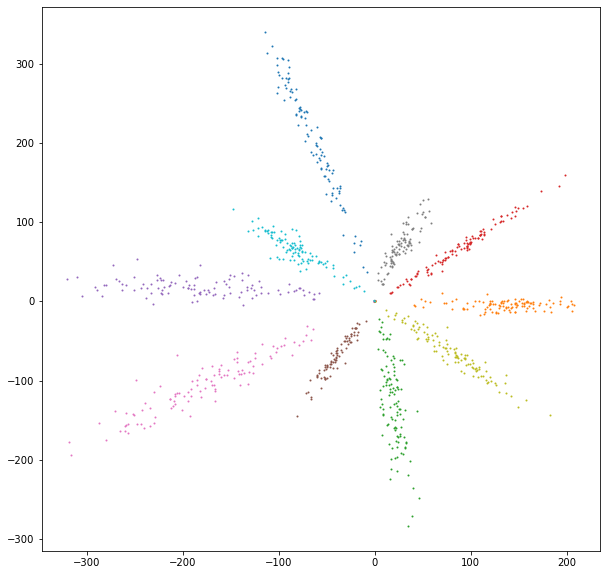

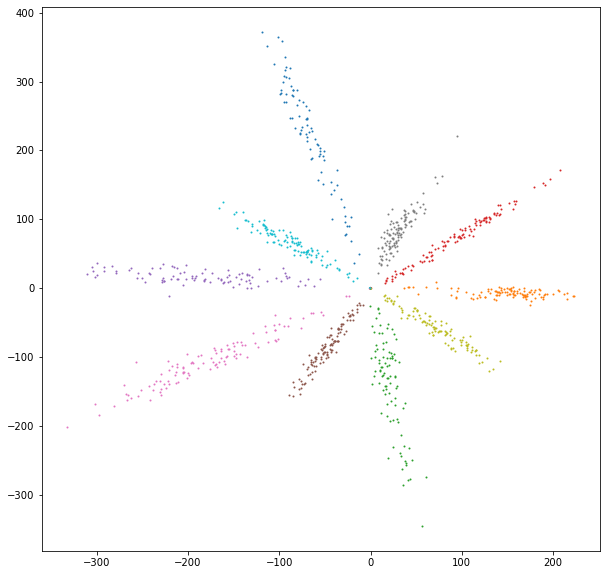

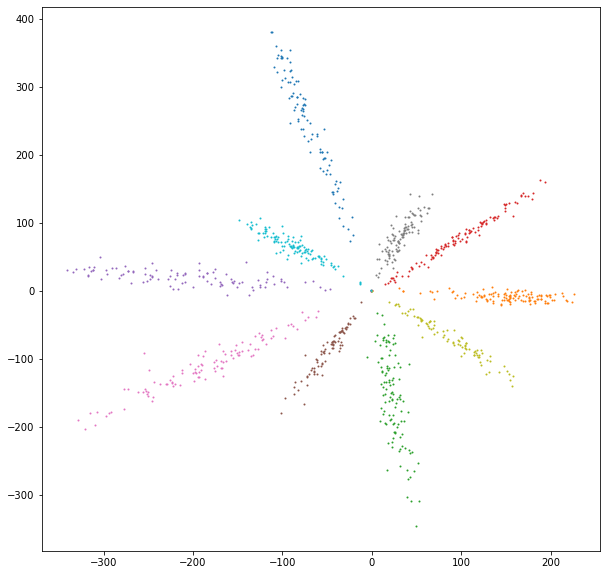

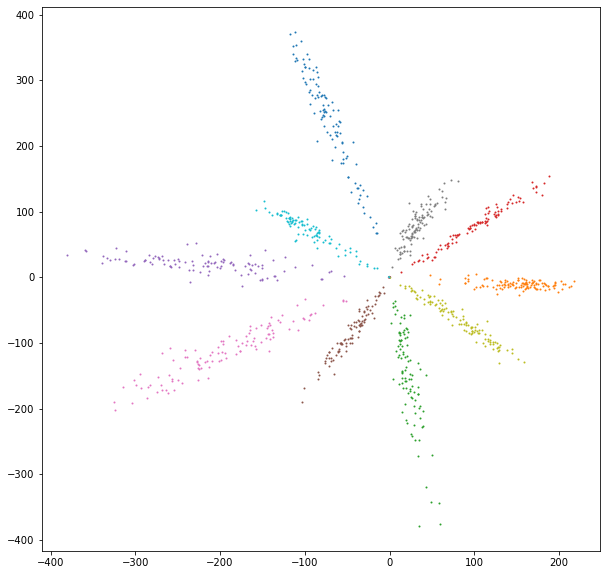

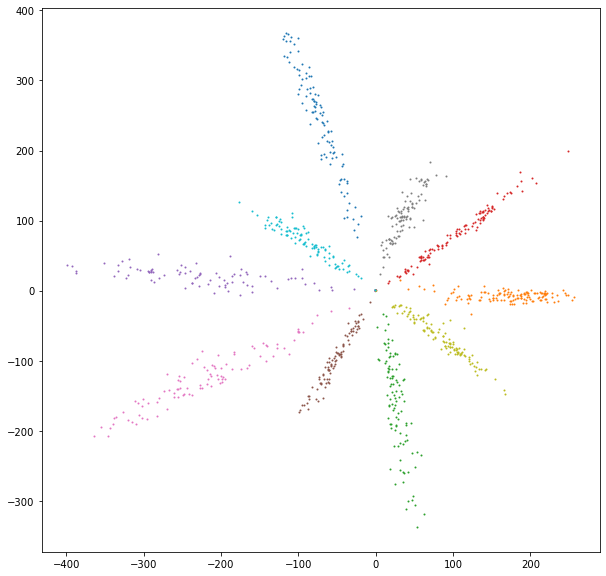

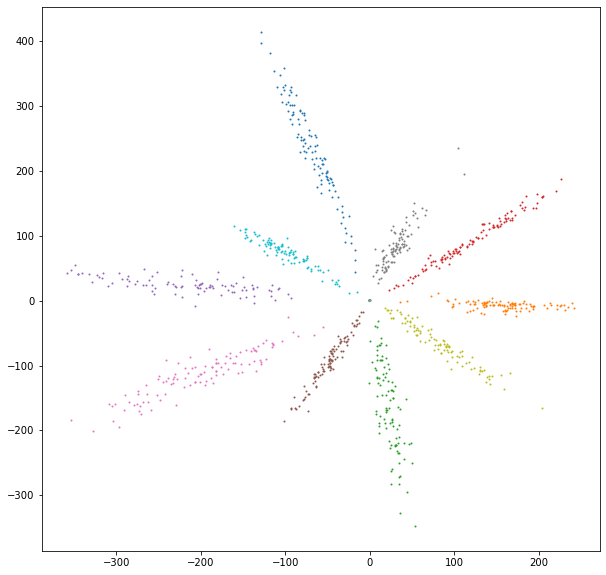

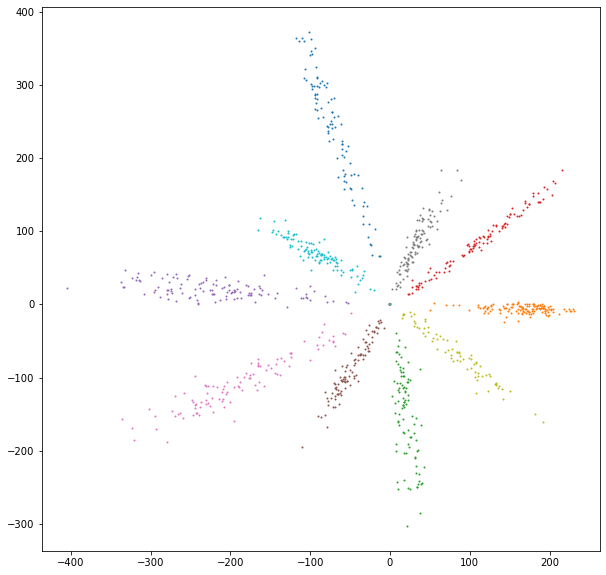

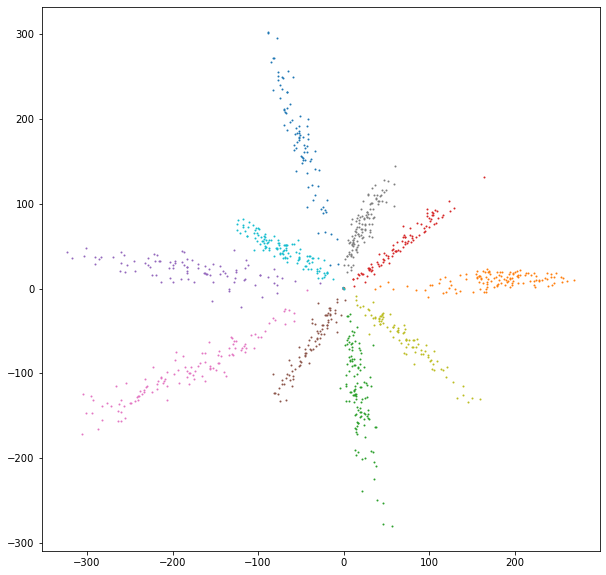

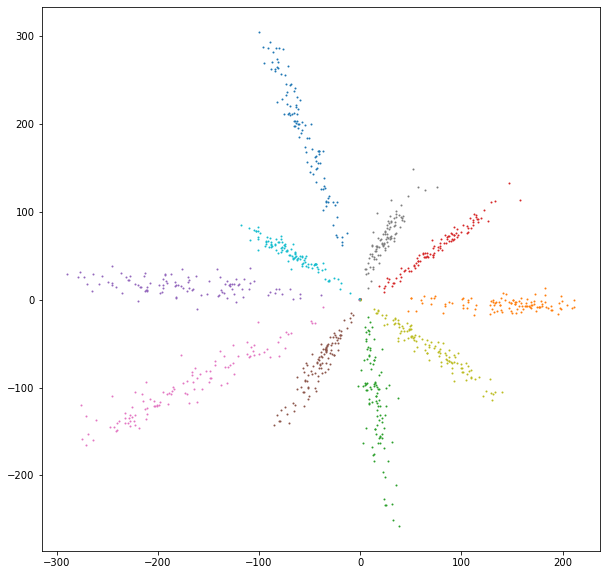

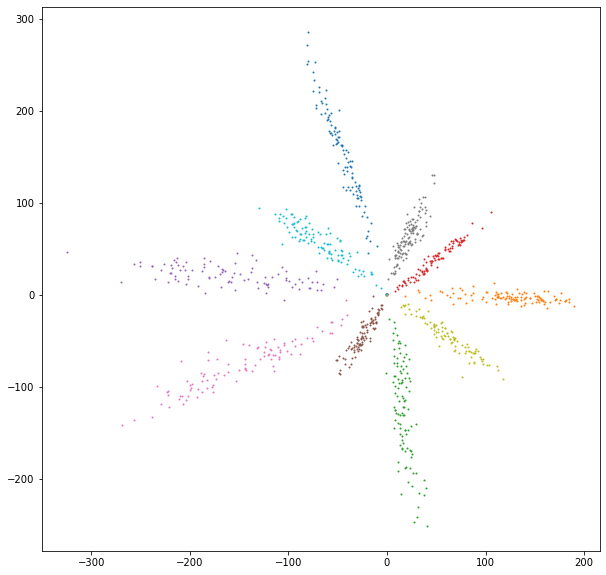

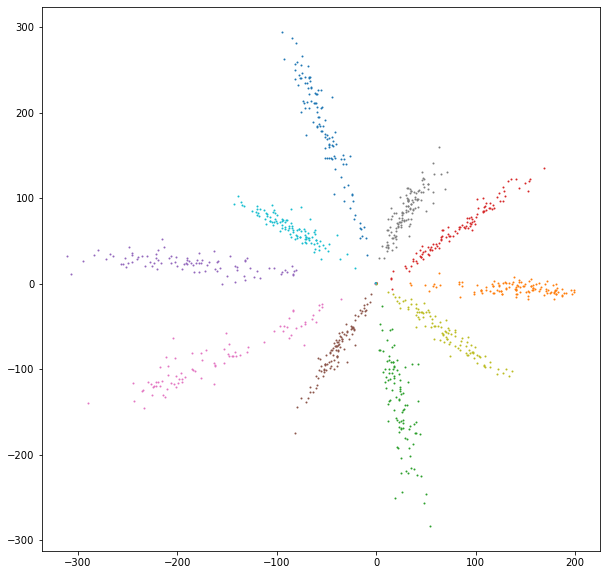

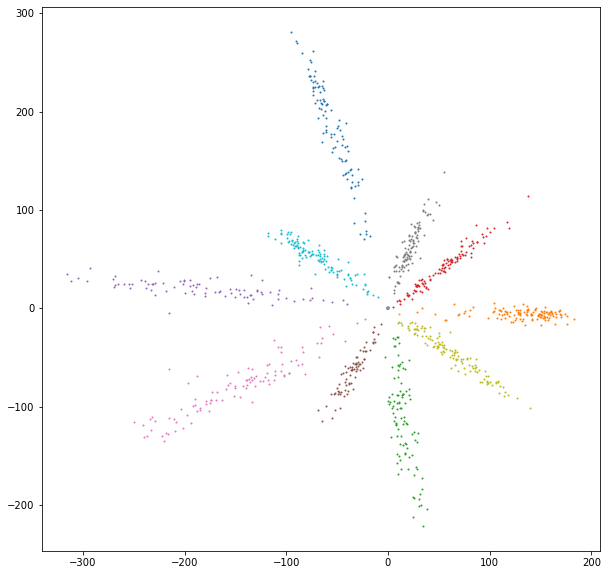

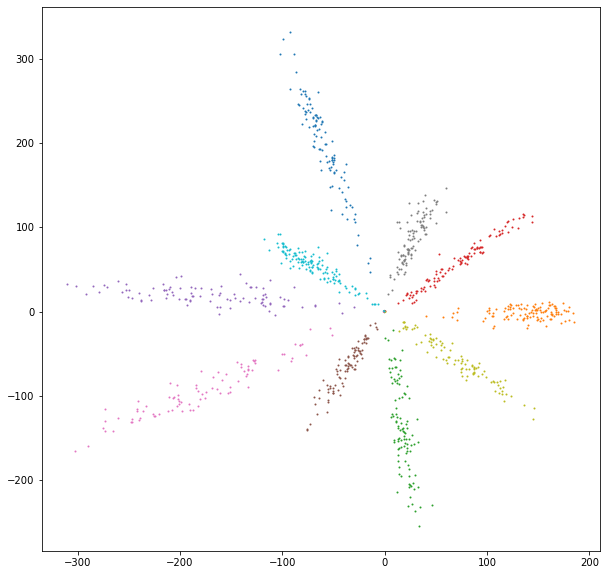

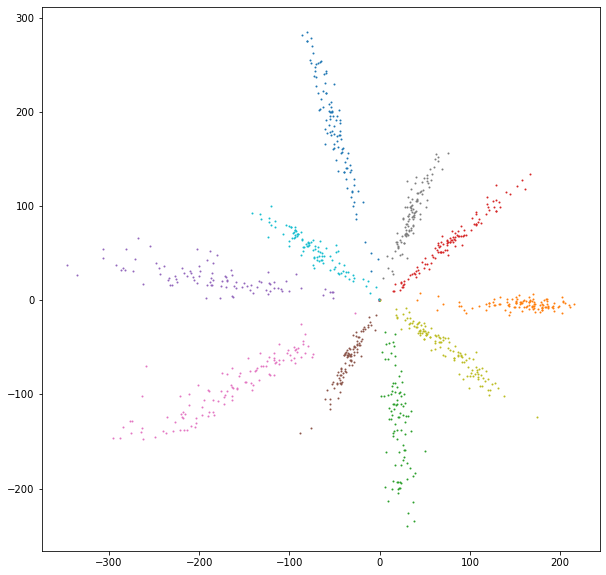

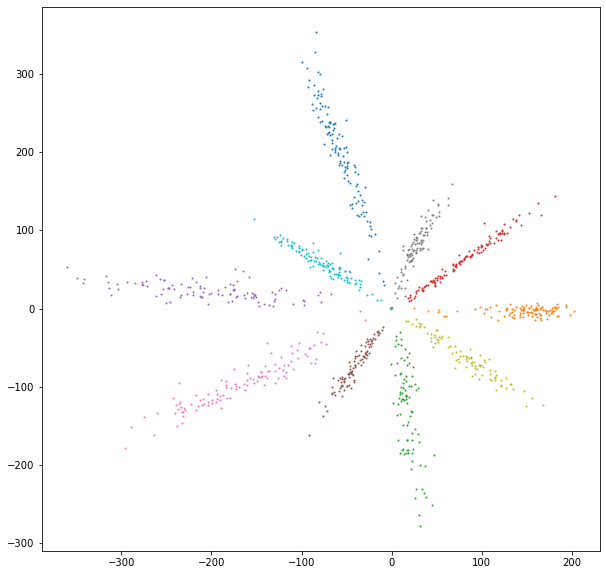

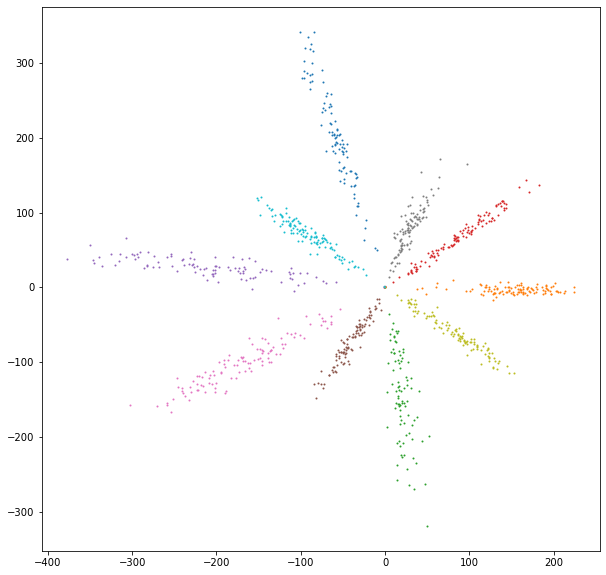

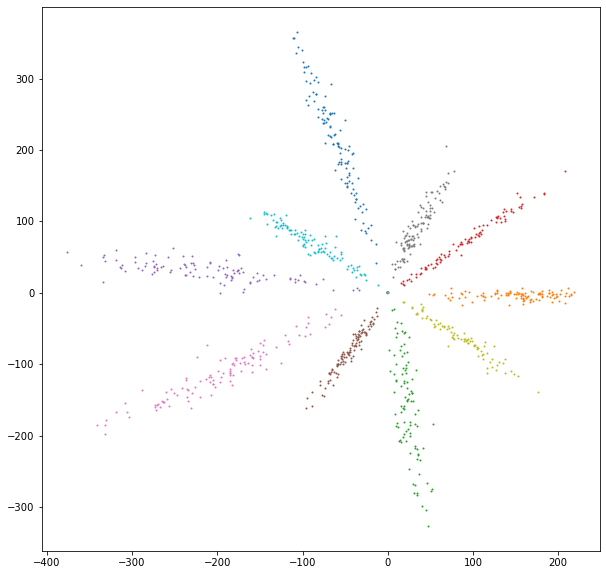

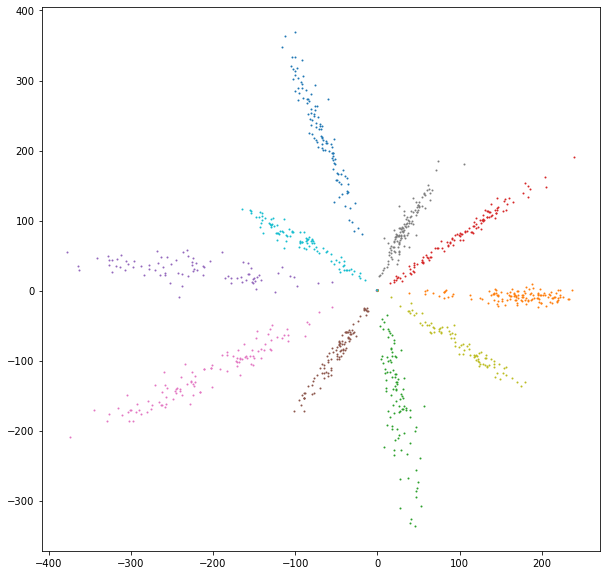

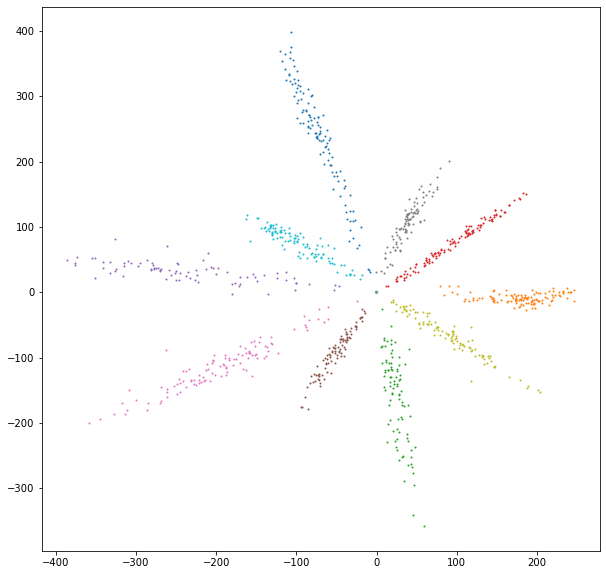

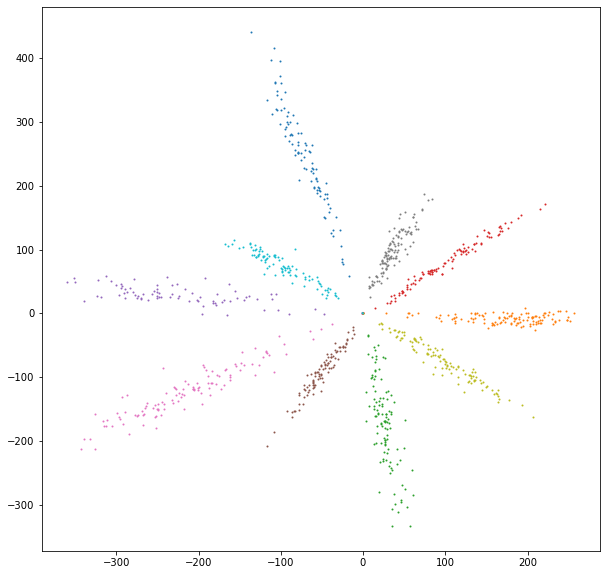

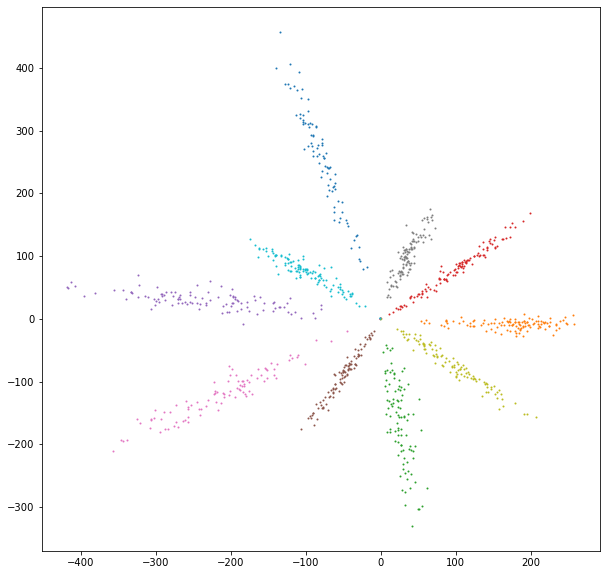

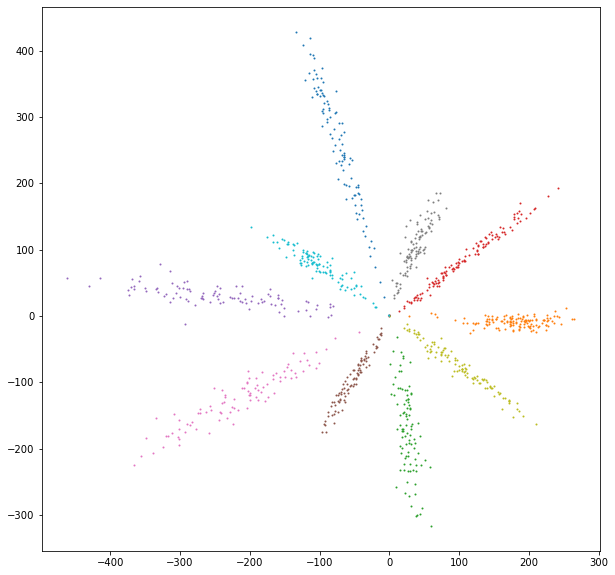

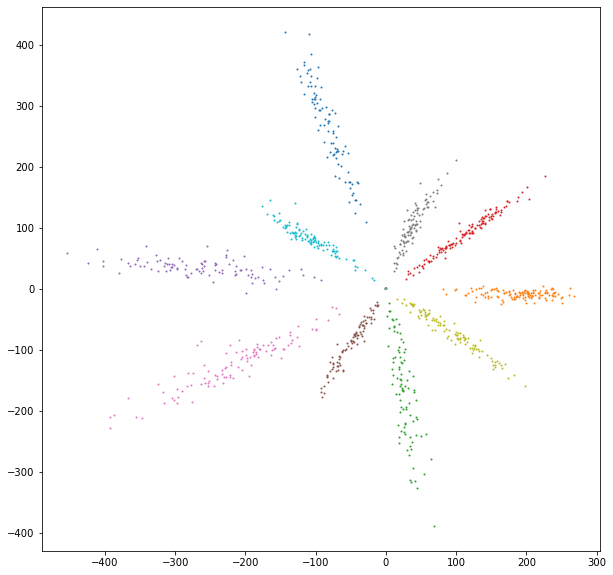

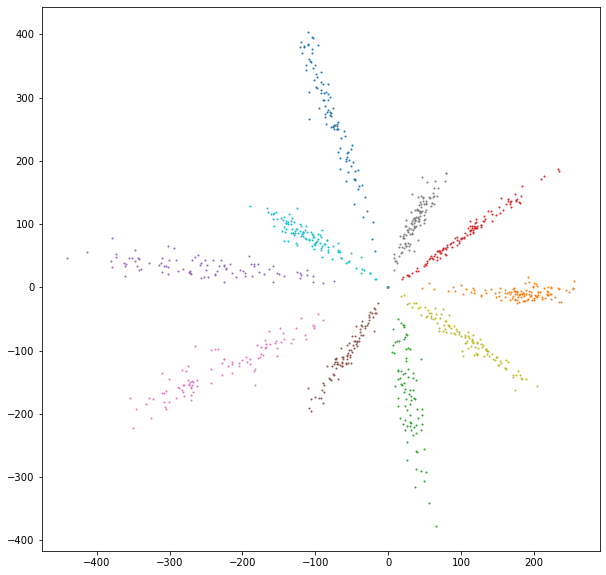

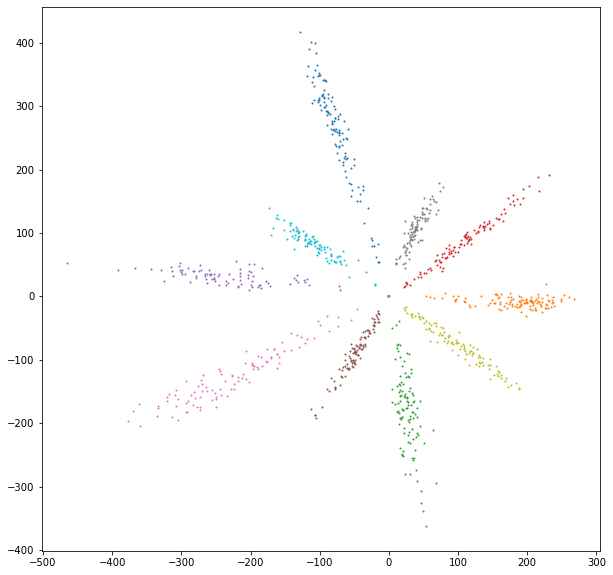

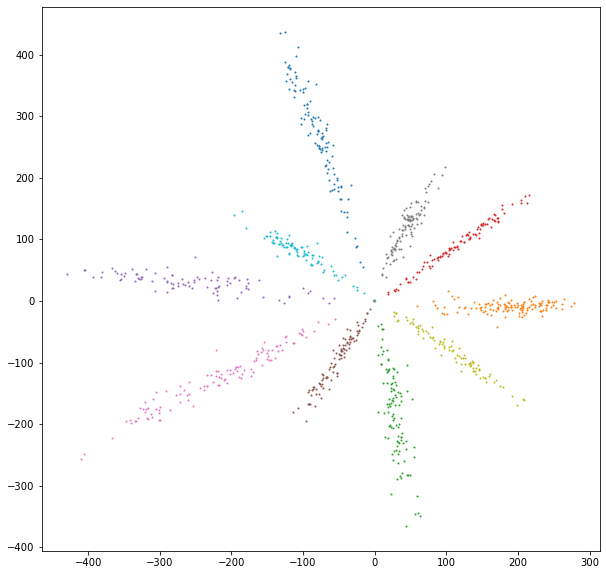

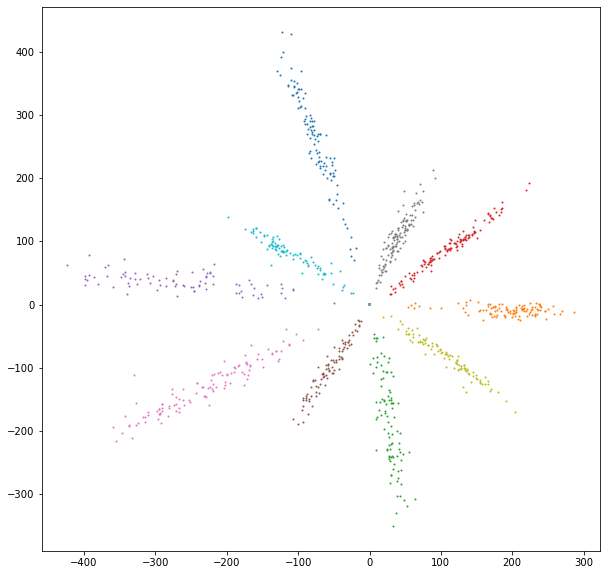

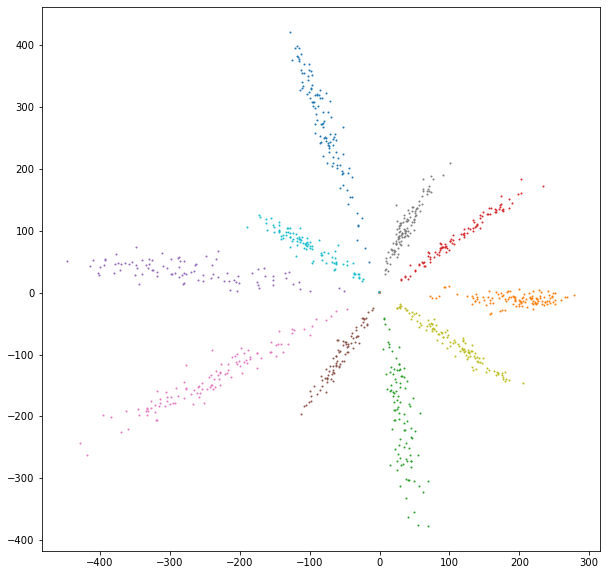

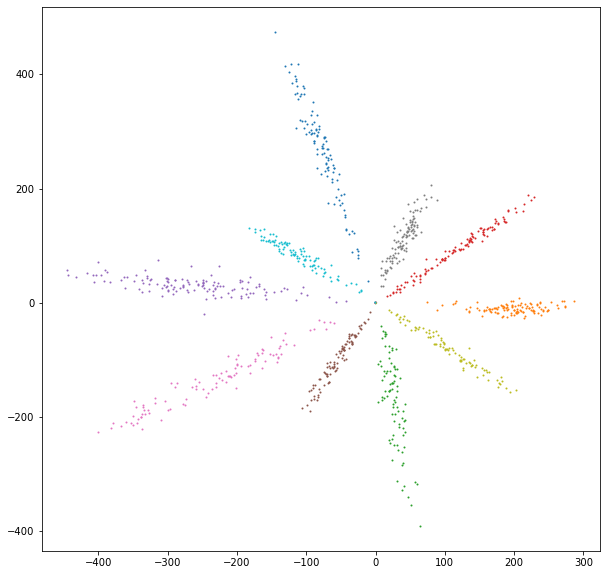

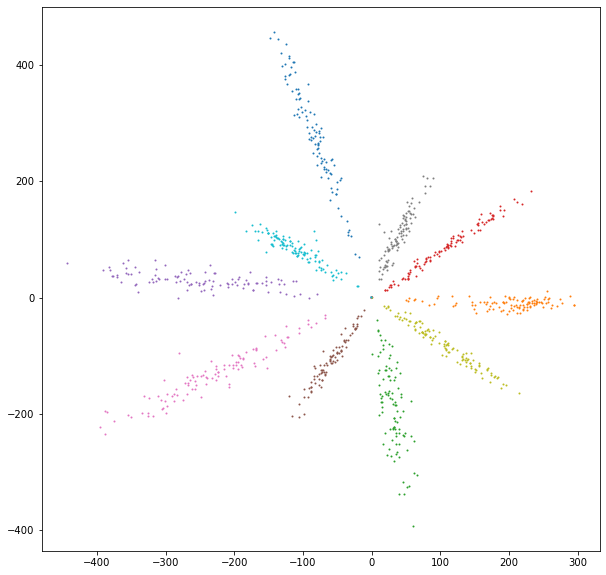

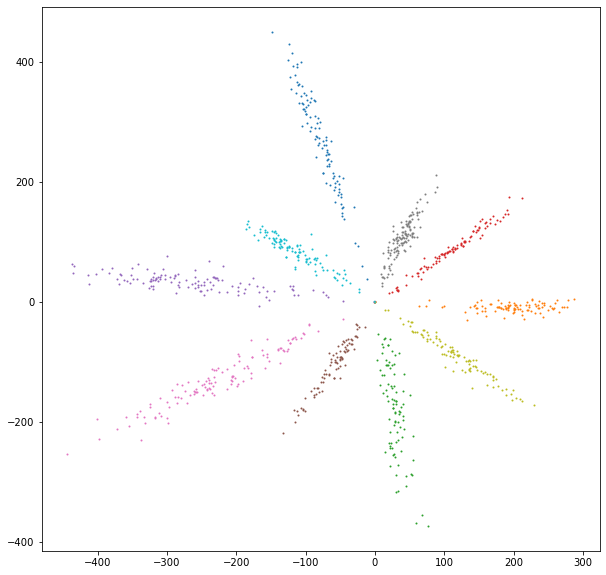

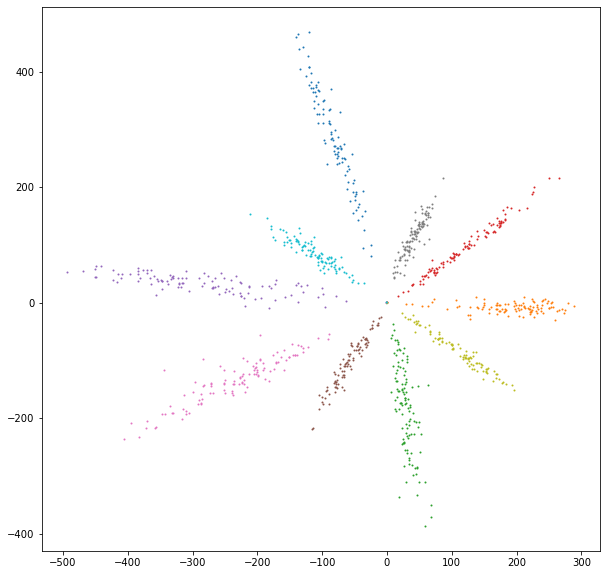

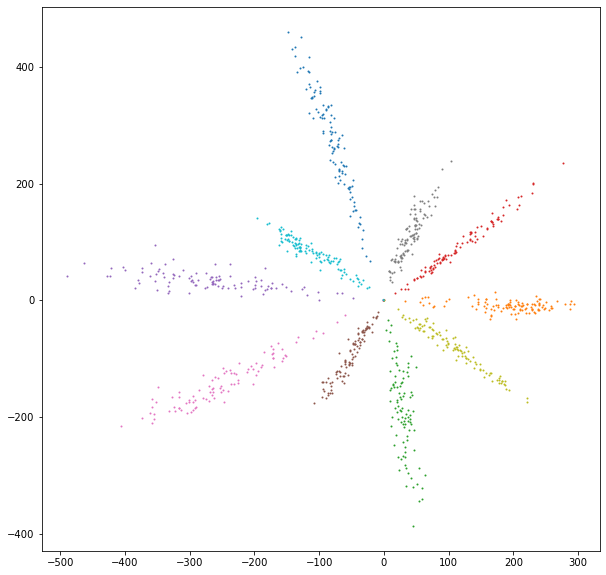

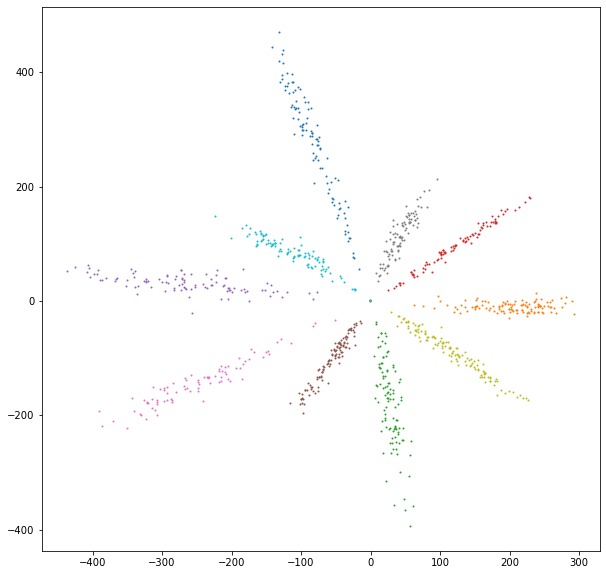

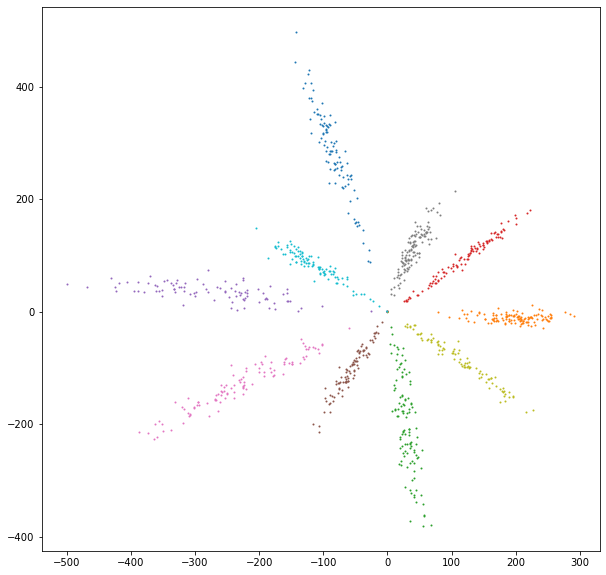

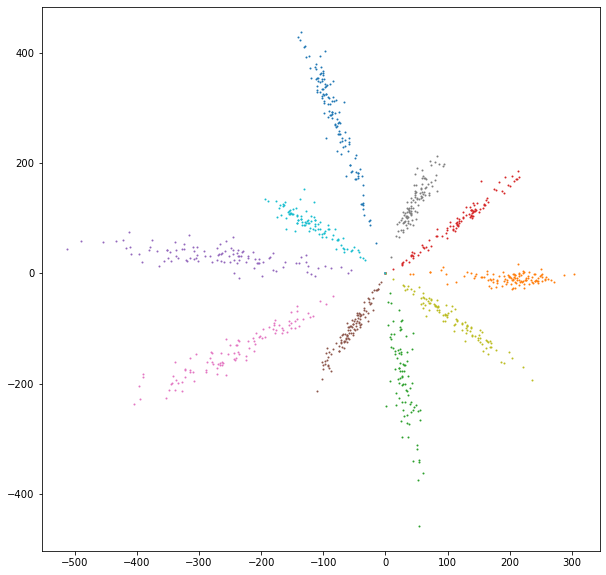

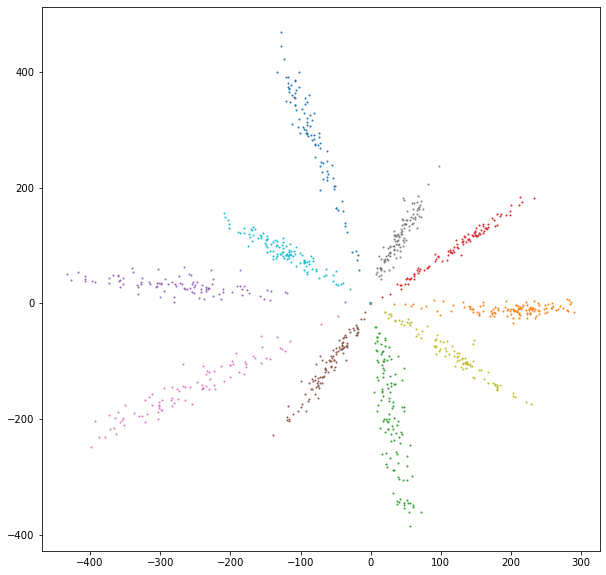

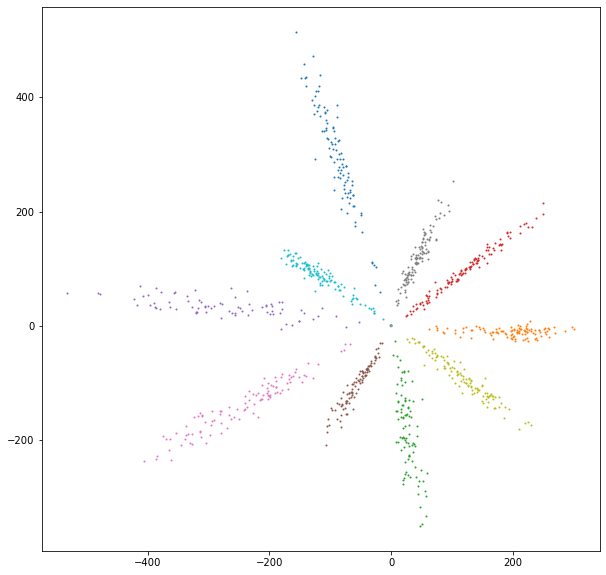

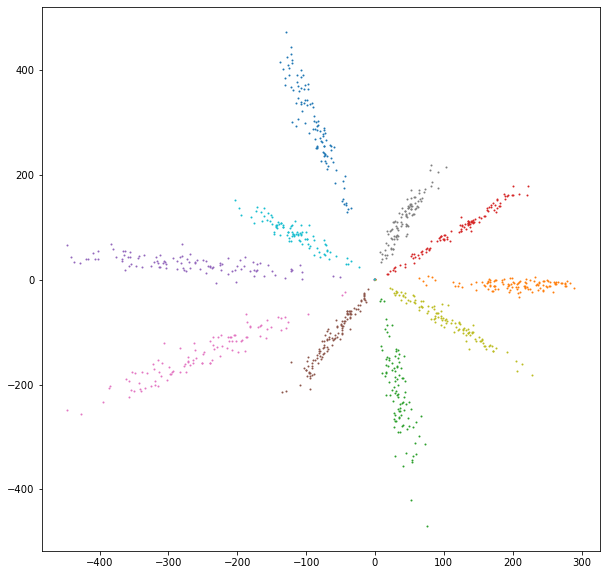

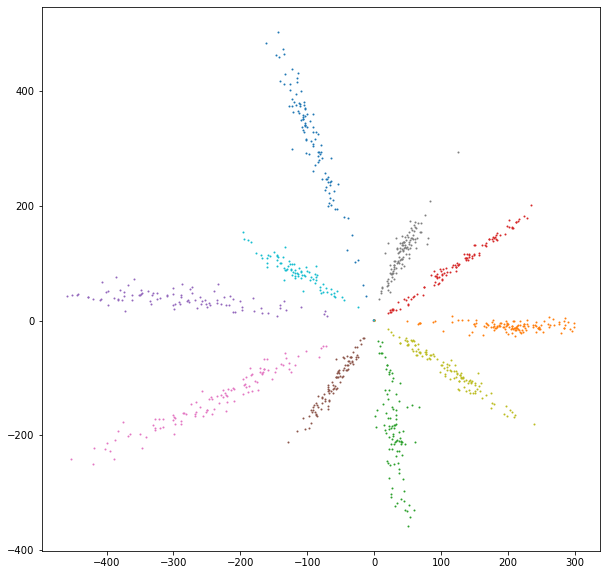

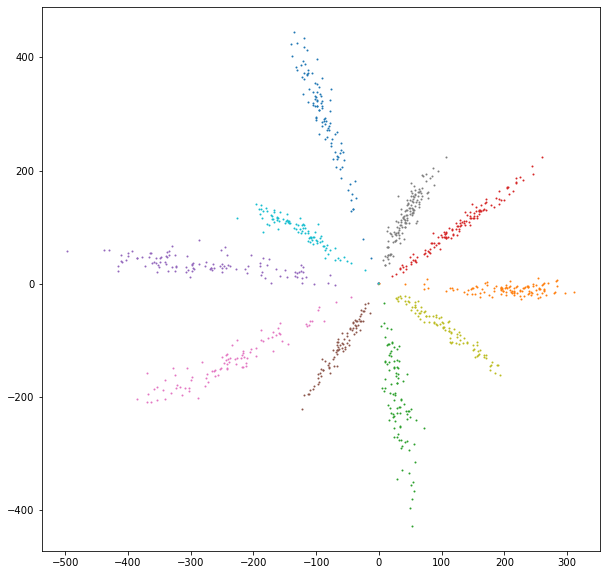

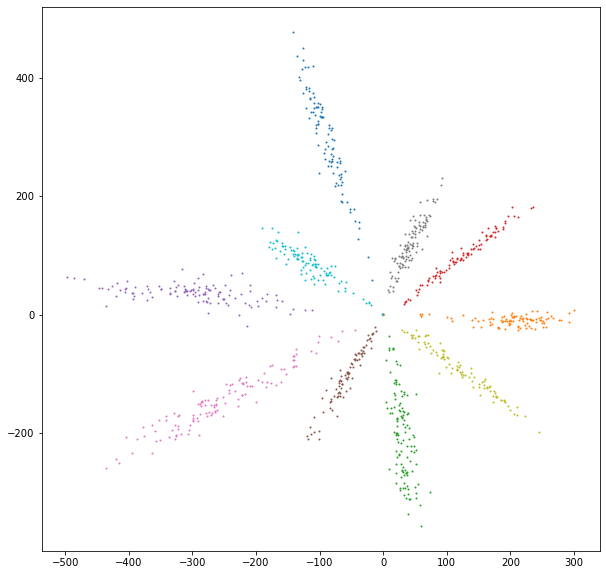

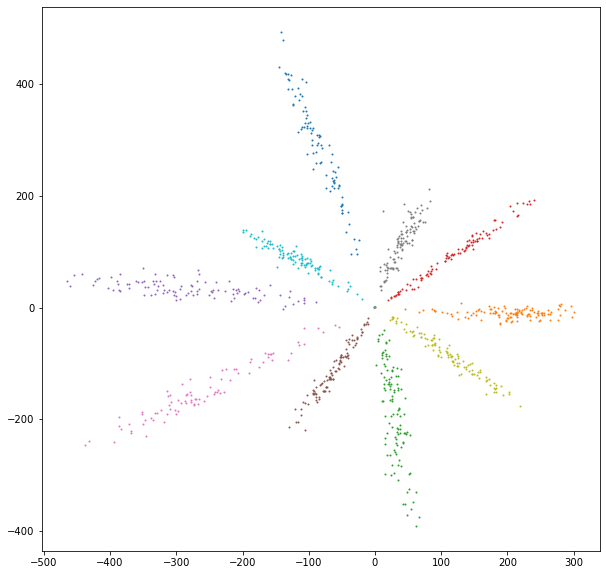

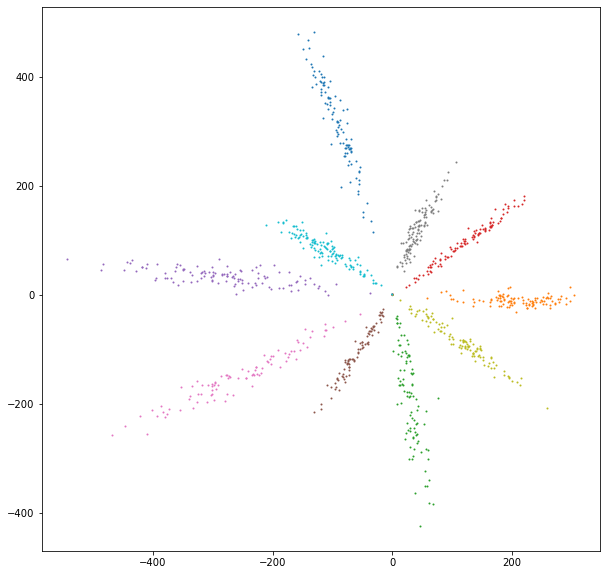

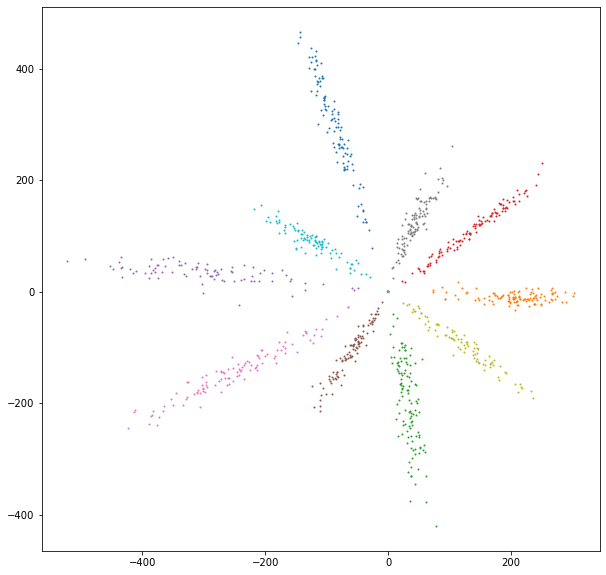

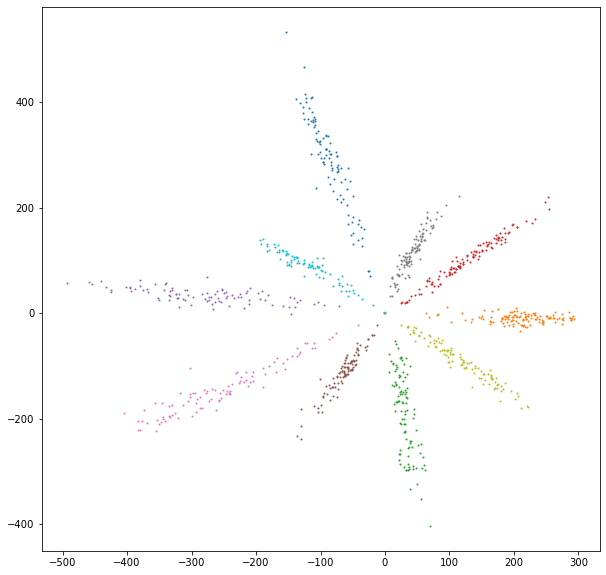

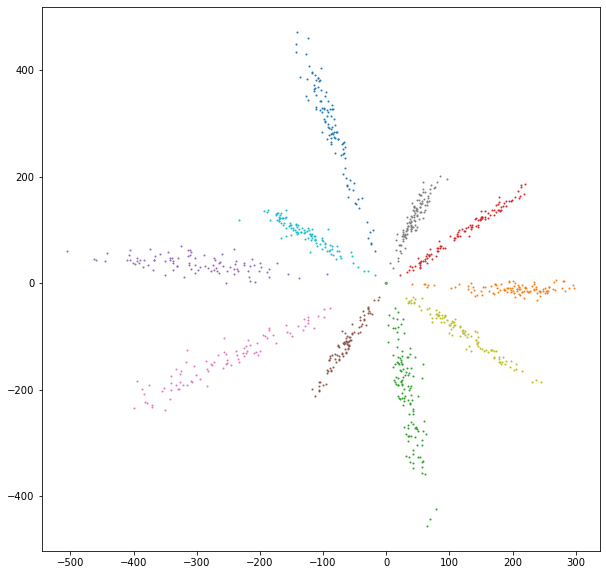

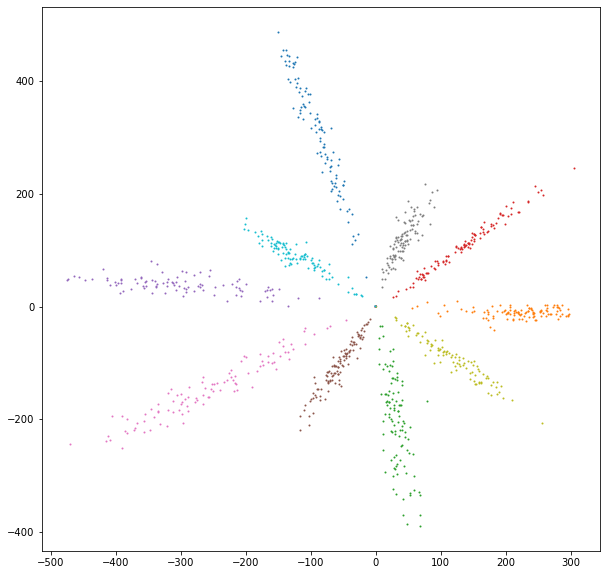

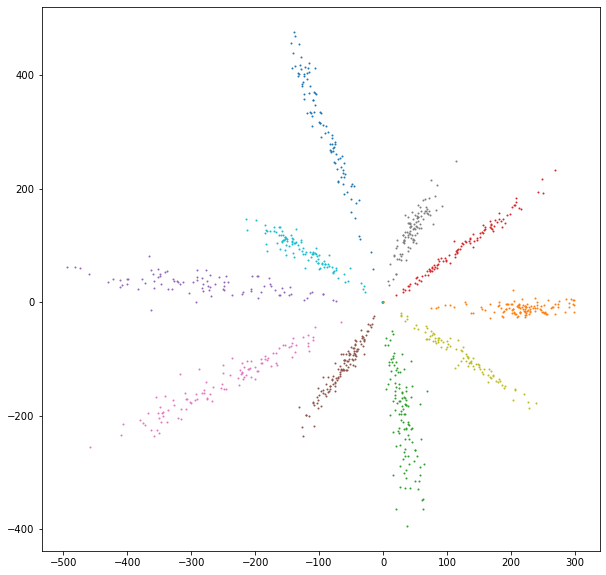

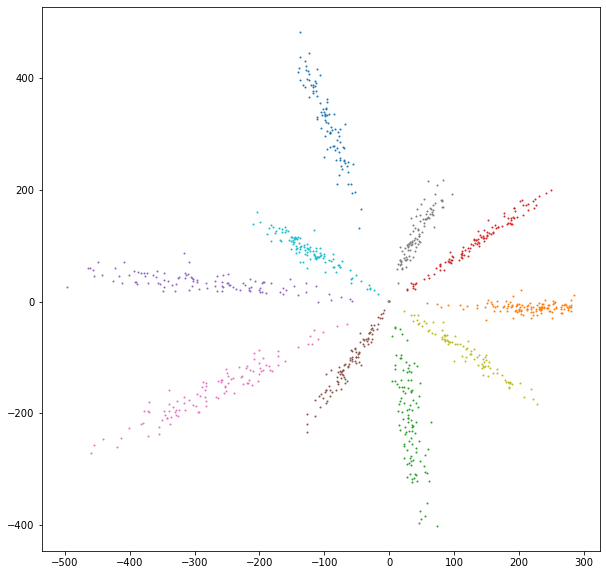

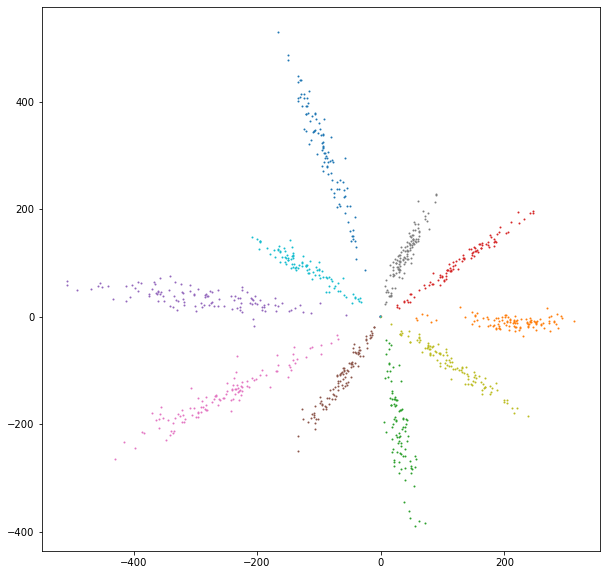

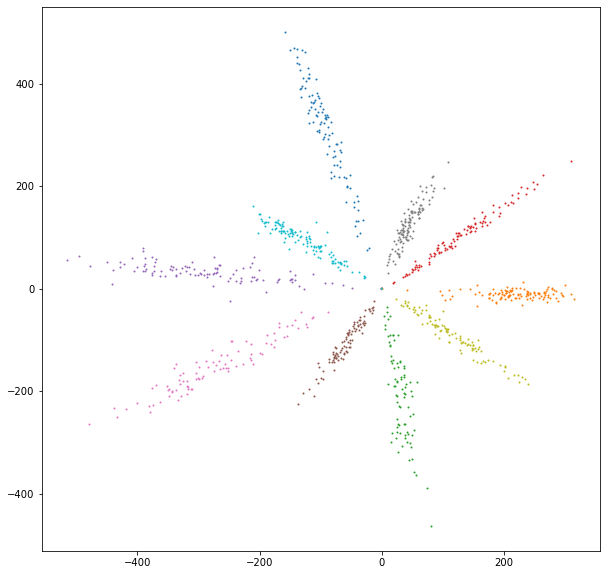

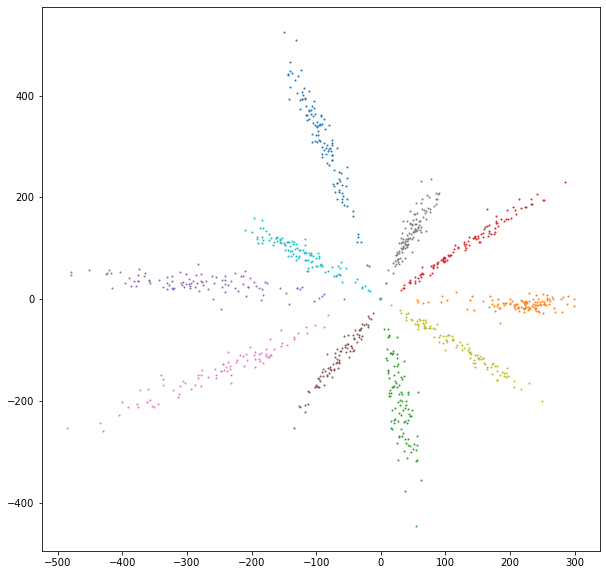

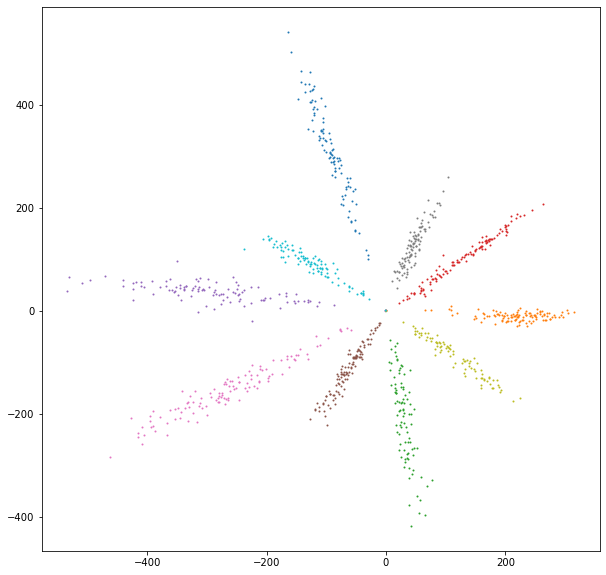

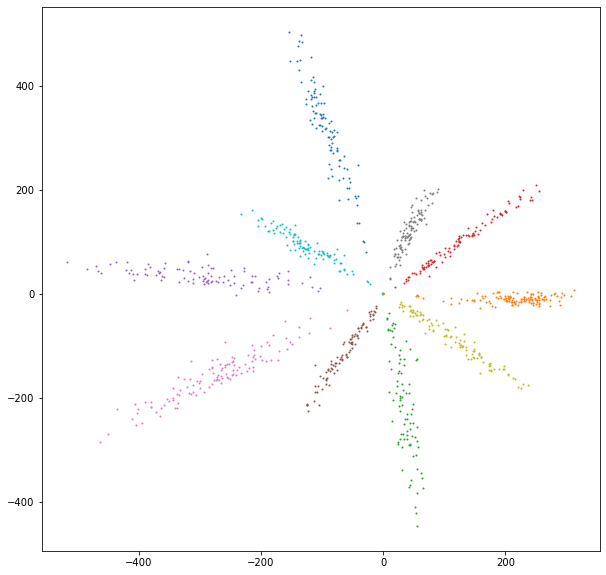

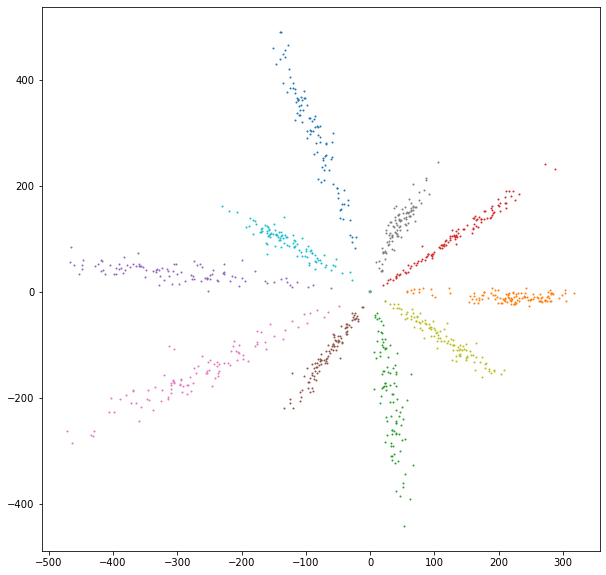

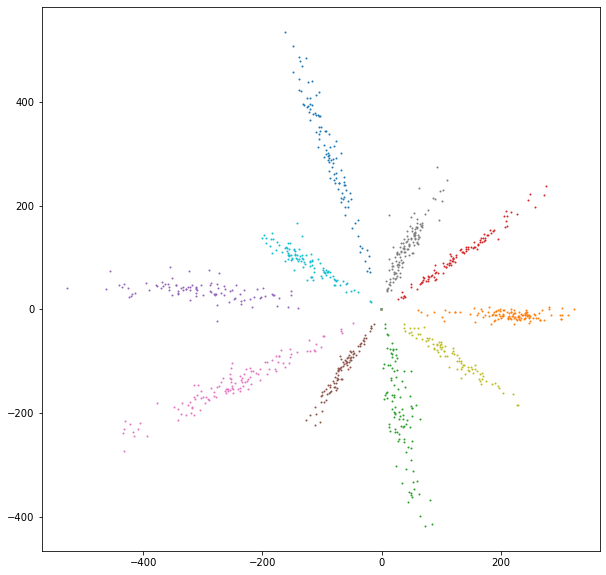

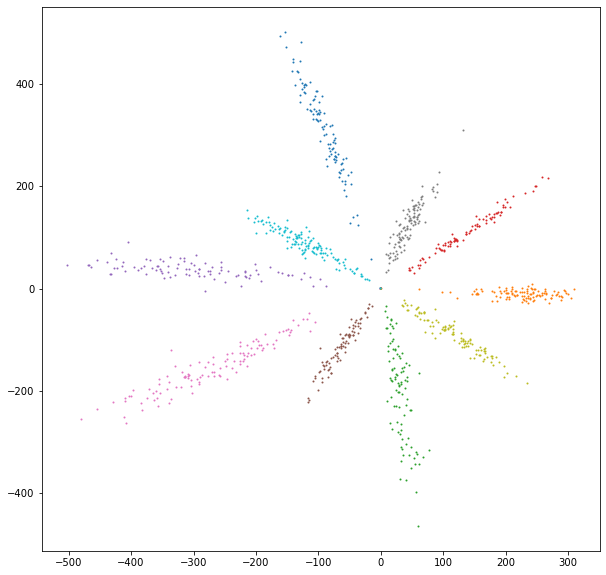

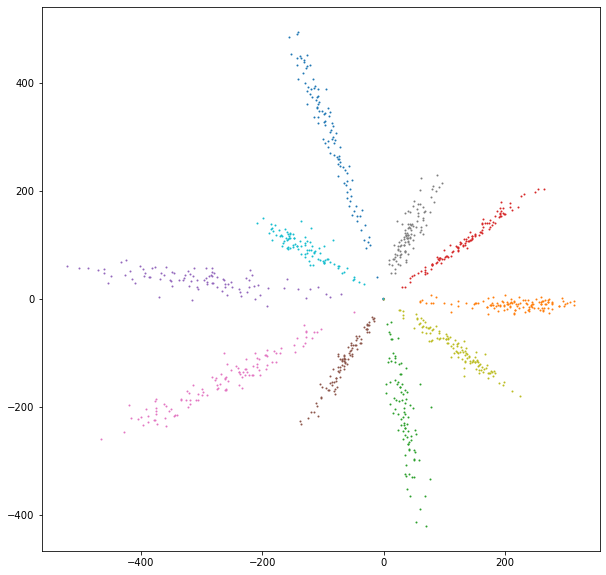

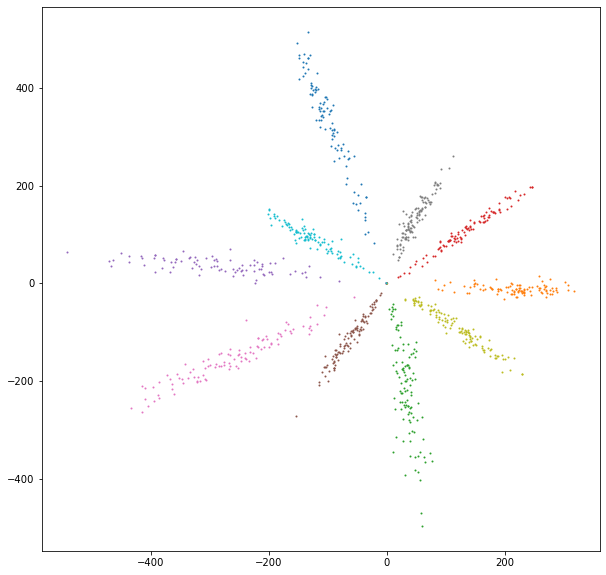

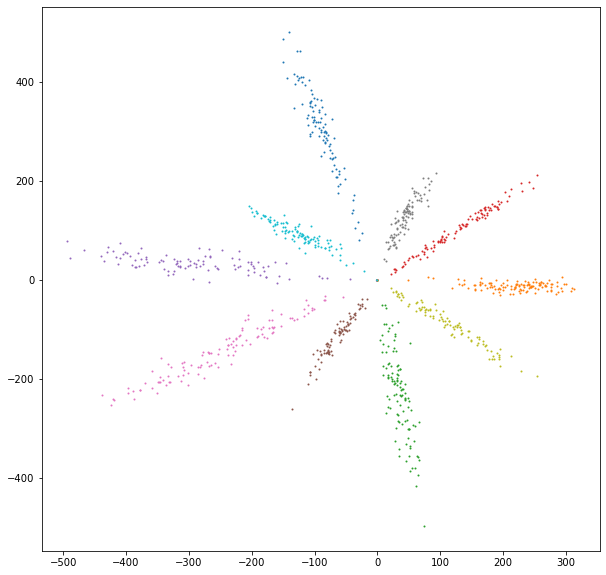

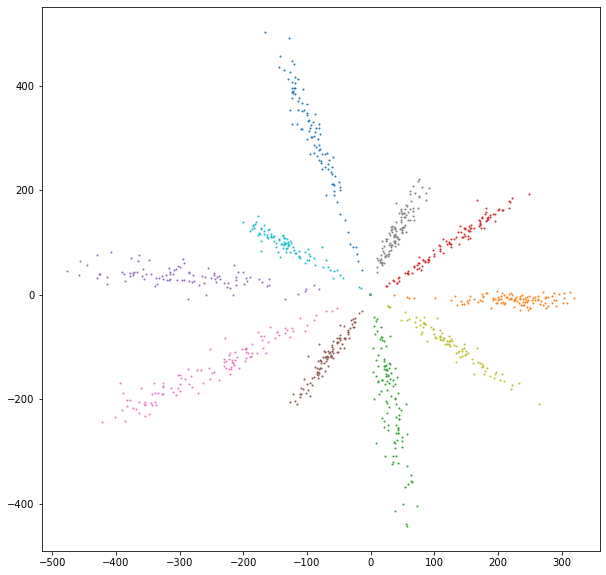

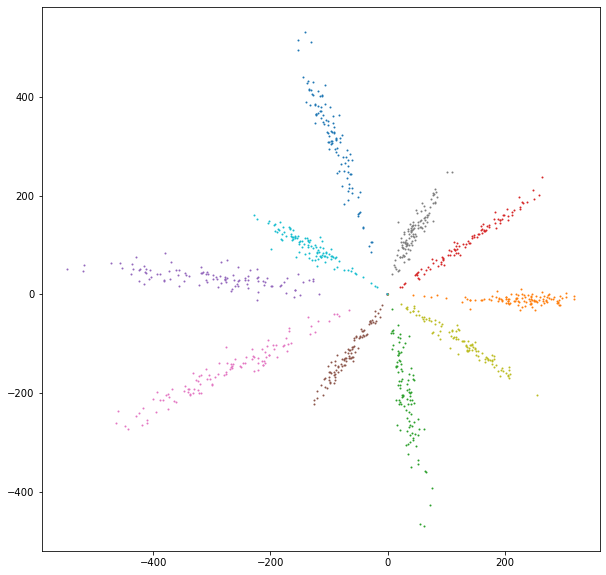

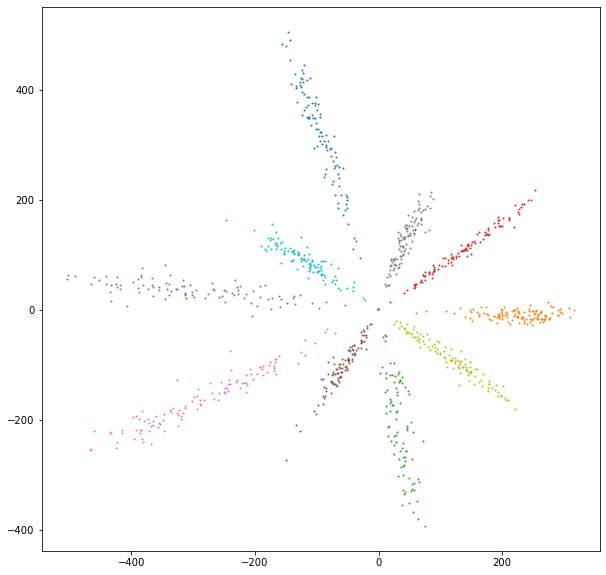

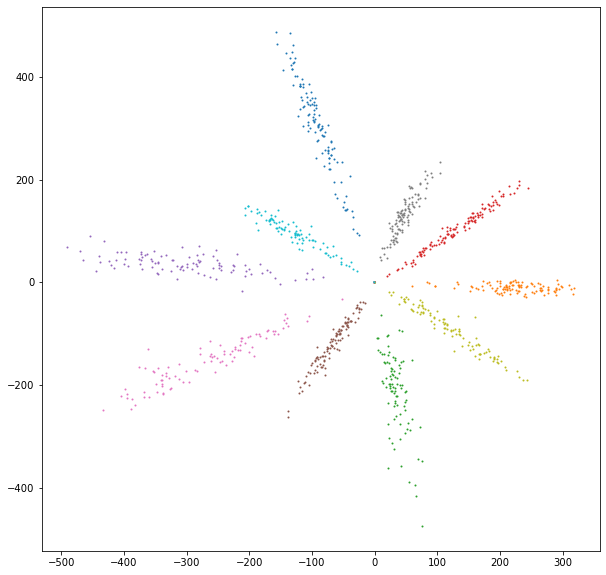

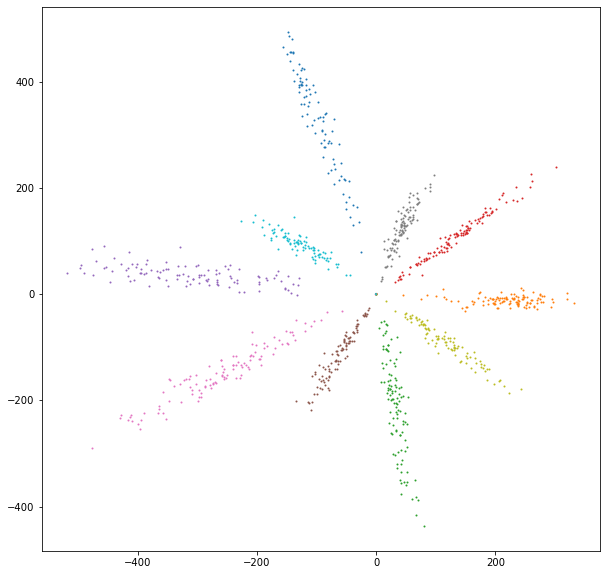

In [14]:
for epoch in range(0,100) :
    train(lenet,epoch)